# Problem Description

The problem is to predict which Tweets are about real disasters and which are not. This notebook will be heavily based on the one by Gunes Evitan, which is referenced in the pinned notebook for this Kaggle competition, and will be mainly for my own reference on NLP techniques. 

The data structure is a csv with 5 columns. There is a column for the id of the tweet, the text of the tweet, a keyword from the tweet, and the location the tweet was sent from. The location and keyword may be blank.

The data consists of 7613 tweets, with 3263 tweets for the test set. 

In [1]:
import gc
import re
import string
import operator
from collections import defaultdict
import os
import pickle

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, Embedding, LSTM, GRU, Bidirectional, BatchNormalization, GlobalMaxPooling1D, Attention, Concatenate
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

SEED = 1337

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Exploratory Data Analysis

In [5]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


From the stats, on average the tweets are around 101 characters long, with the shortest tweet being 7 characters long and the longest tweet being 157 characters long. The test dataset is similar. 

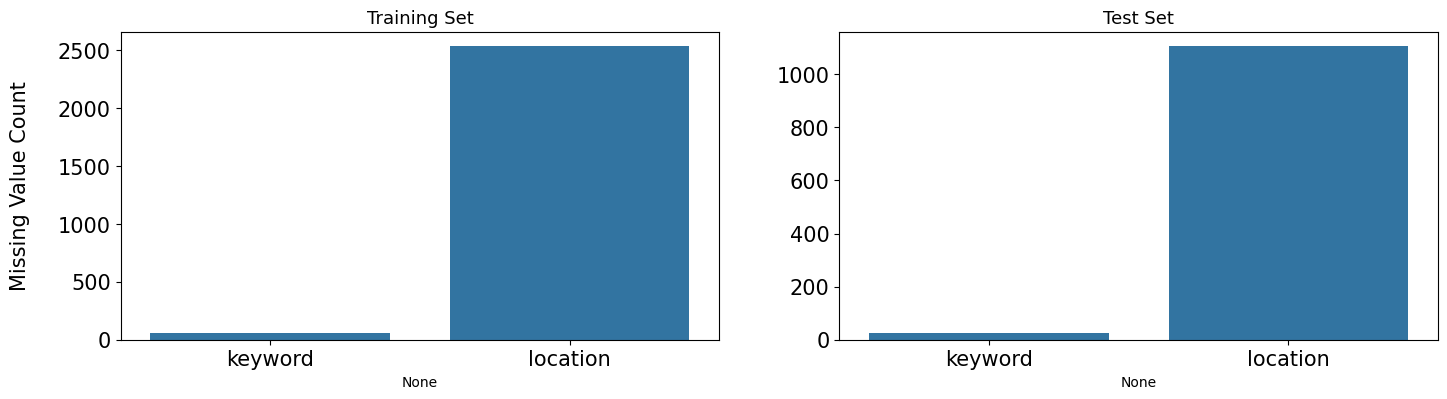

In [6]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

In [7]:
no_keyword_count = len(df_train[df_train['keyword'] == 'no_keyword'])
no_location_count = len(df_train[df_train['location'] == 'no_location'])

print('There are ' + str(no_keyword_count / len(df_train) * 100)[:4] + '% tweets with no keywords.')
print('There are ' + str(no_location_count / len(df_train) * 100)[:4] + '% tweets with no locations.')

There are 0.80% tweets with no keywords.
There are 33.2% tweets with no locations.


In [8]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


From checking the number of unique keywords and locations, it looks like there are a lot of overlapping keywords, but not many overlapping locations. Because of this, keywords may be a usable signal, but location will be much noisier. 

Doing a group by on the different keywords, the histogram below shows the distributions between the different keywords and the amounts of tweets that are classified as disasters. 

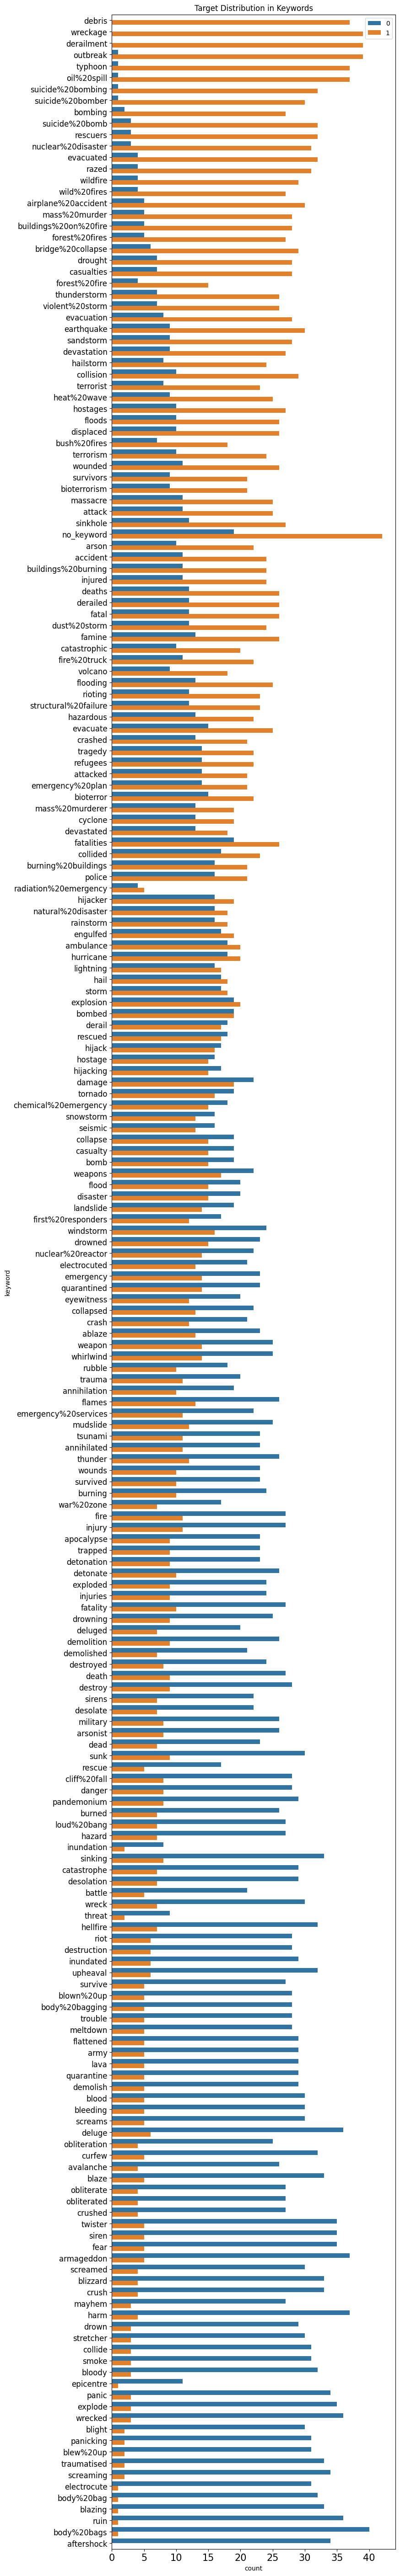

In [9]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

From Gunes Evitan's notebook: "Distributions of meta features in classes and datasets can be helpful to identify disaster tweets. It looks like disaster tweets are written in a more formal way with longer words compared to non-disaster tweets because most of them are coming from news agencies. Non-disaster tweets have more typos than disaster tweets because they are coming from individual users."

Extra features are created for the following:

- word count
- unique word count
- stop word count (from wordcloud)
- url count
- average word length
- character count
- punctuation count
- hashtag count
- mention count

In [10]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

Comparing the distributions between the training and test set for the features created as well as the distribution between disaster and non-disaster tweets, we can see that the distribution between the training and test sets are pretty similar. In terms of the features, url count, hashtag count, and mention count don't look useful from their small distributions. The other features may be useful. 

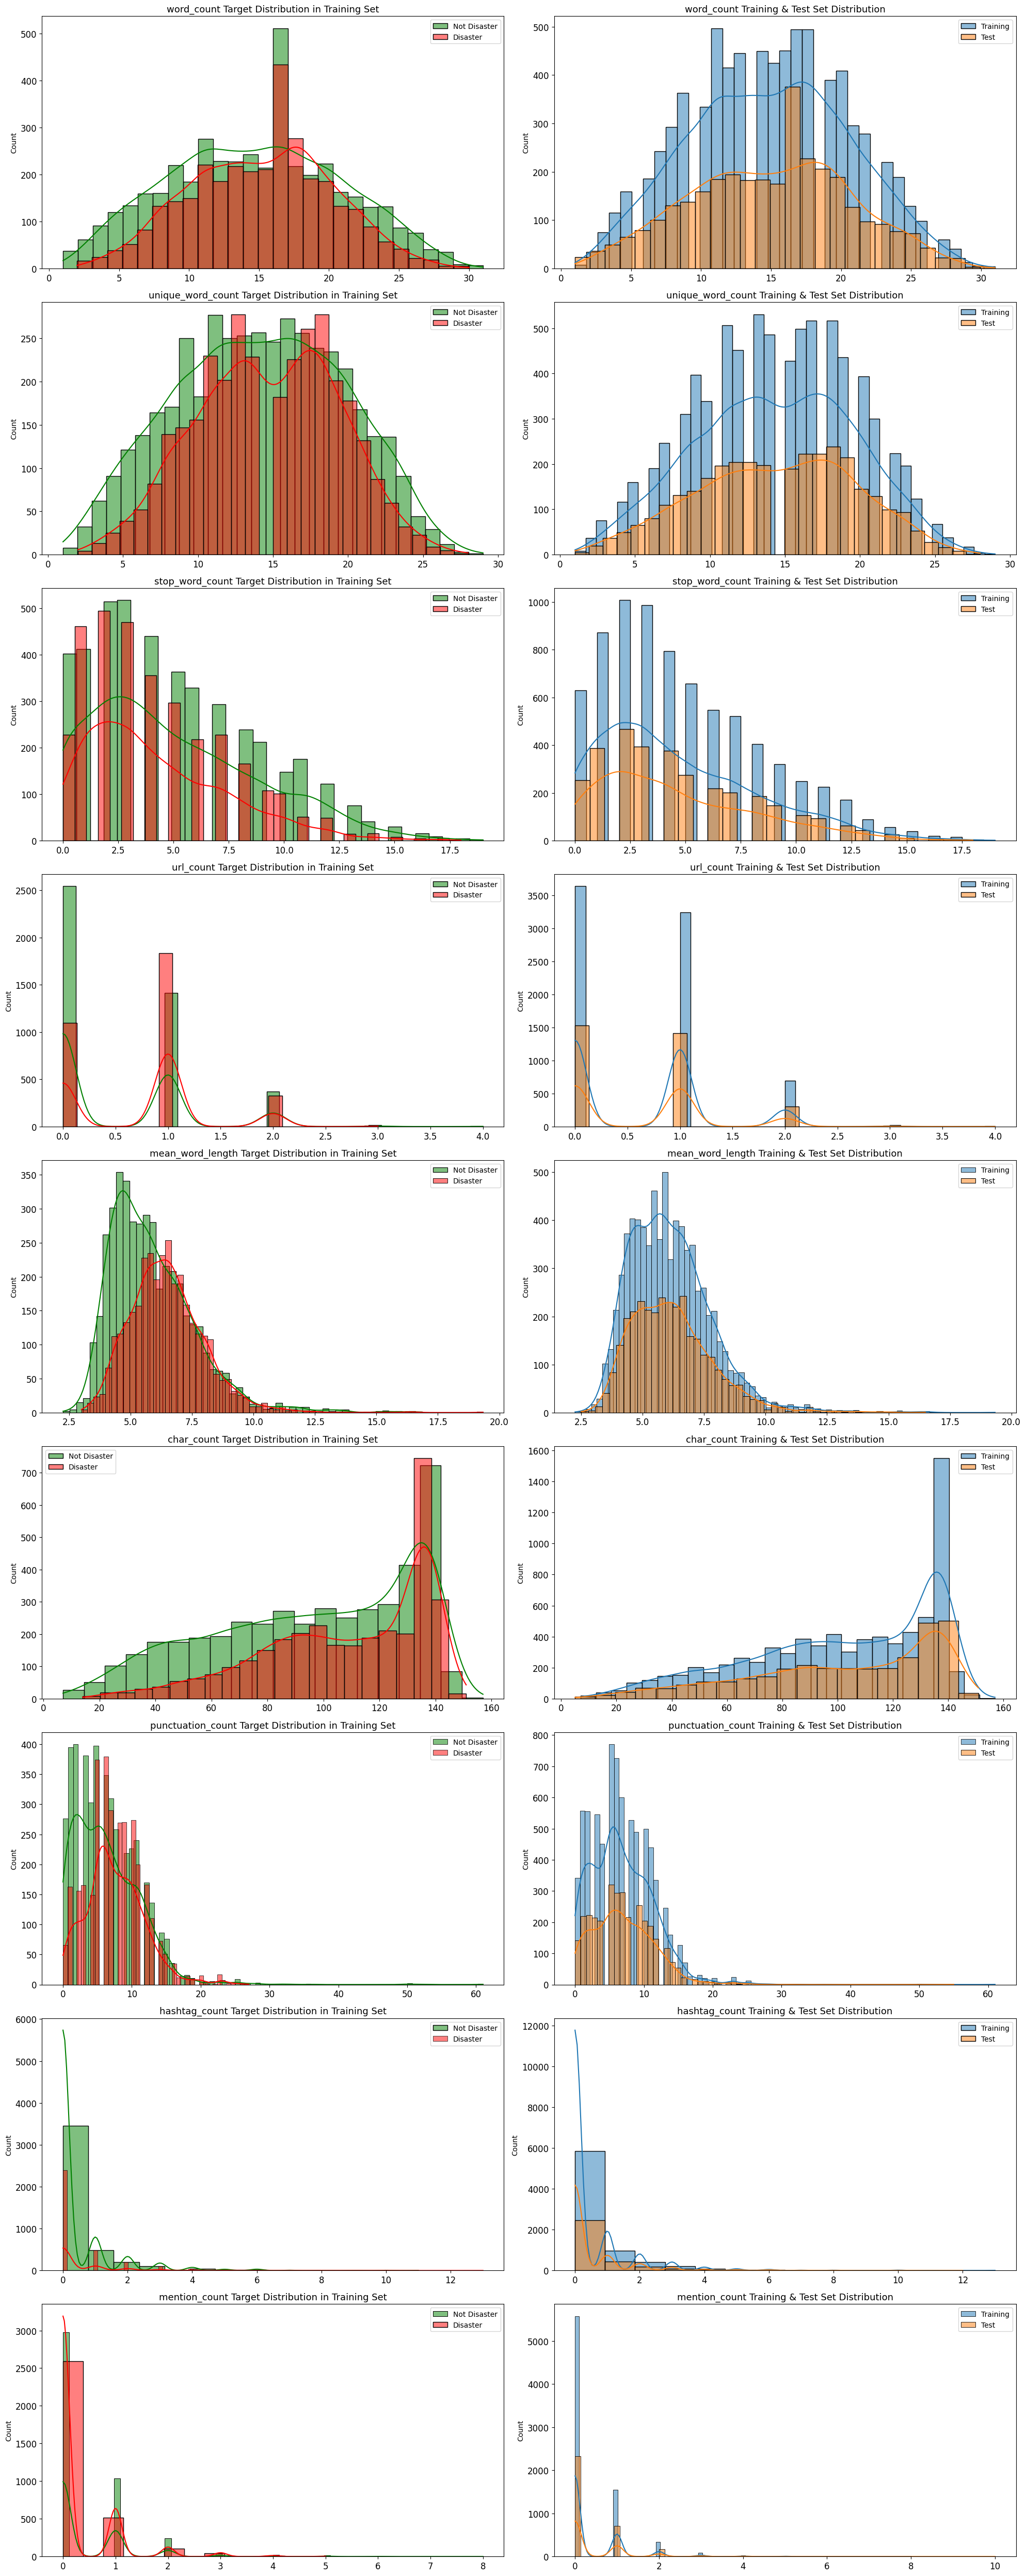

In [11]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

# Replace inf values with NaN
df_train[METAFEATURES] = df_train[METAFEATURES].replace([np.inf, -np.inf], np.nan)
df_test[METAFEATURES] = df_test[METAFEATURES].replace([np.inf, -np.inf], np.nan)

DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.histplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green', kde=True)
    sns.histplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red', kde=True)
    
    sns.histplot(df_train[feature], label='Training', ax=axes[i][1], kde=True)
    sns.histplot(df_test[feature], label='Test', ax=axes[i][1], kde=True)
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.tight_layout()
plt.show()

In [12]:
df_train.describe()

,id,target,length,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count
count,7613.000000,7613.00000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000,7613.000000
mean,5441.934848,0.42966,101.037436,14.903586,14.340733,4.672928,0.620255,6.128494,101.037436,6.839485,0.446999,0.362406
std,3137.116090,0.49506,33.781325,5.732604,5.277160,3.559228,0.664104,1.675464,33.781325,4.608758,1.099841,0.720097
min,1.000000,0.00000,7.000000,1.000000,1.000000,0.000000,0.000000,2.250000,7.000000,0.000000,0.000000,0.000000
25%,2734.000000,0.00000,78.000000,11.000000,11.000000,2.000000,0.000000,4.875000,78.000000,3.000000,0.000000,0.000000
50%,5408.000000,0.00000,107.000000,15.000000,14.000000,4.000000,1.000000,5.928571,107.000000,6.000000,0.000000,0.000000
75%,8146.000000,1.00000,133.000000,19.000000,18.000000,7.000000,1.000000,7.058824,133.000000,10.000000,0.000000,1.000000
max,10873.000000,1.00000,157.000000,31.000000,29.000000,19.000000,4.000000,19.333333,157.000000,61.000000,13.000000,8.000000


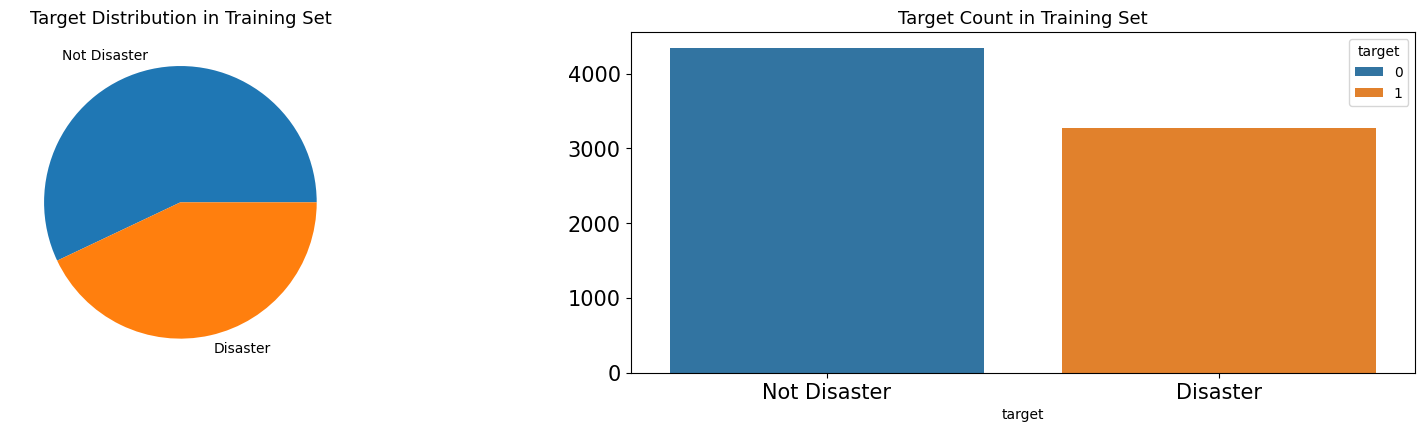

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster', 'Disaster'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster', 'Disaster'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

The data is fairly balanced as shown from the mean on target, with around 43% being a disaster and 57% being not a disaster. 

In [14]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

N = 100

# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        disaster_unigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet):
        nondisaster_unigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        disaster_bigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=2):
        nondisaster_bigrams[word] += 1
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

# Trigrams
disaster_trigrams = defaultdict(int)
nondisaster_trigrams = defaultdict(int)

for tweet in df_train[DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        disaster_trigrams[word] += 1
        
for tweet in df_train[~DISASTER_TWEETS]['text']:
    for word in generate_ngrams(tweet, n_gram=3):
        nondisaster_trigrams[word] += 1
        
df_disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])

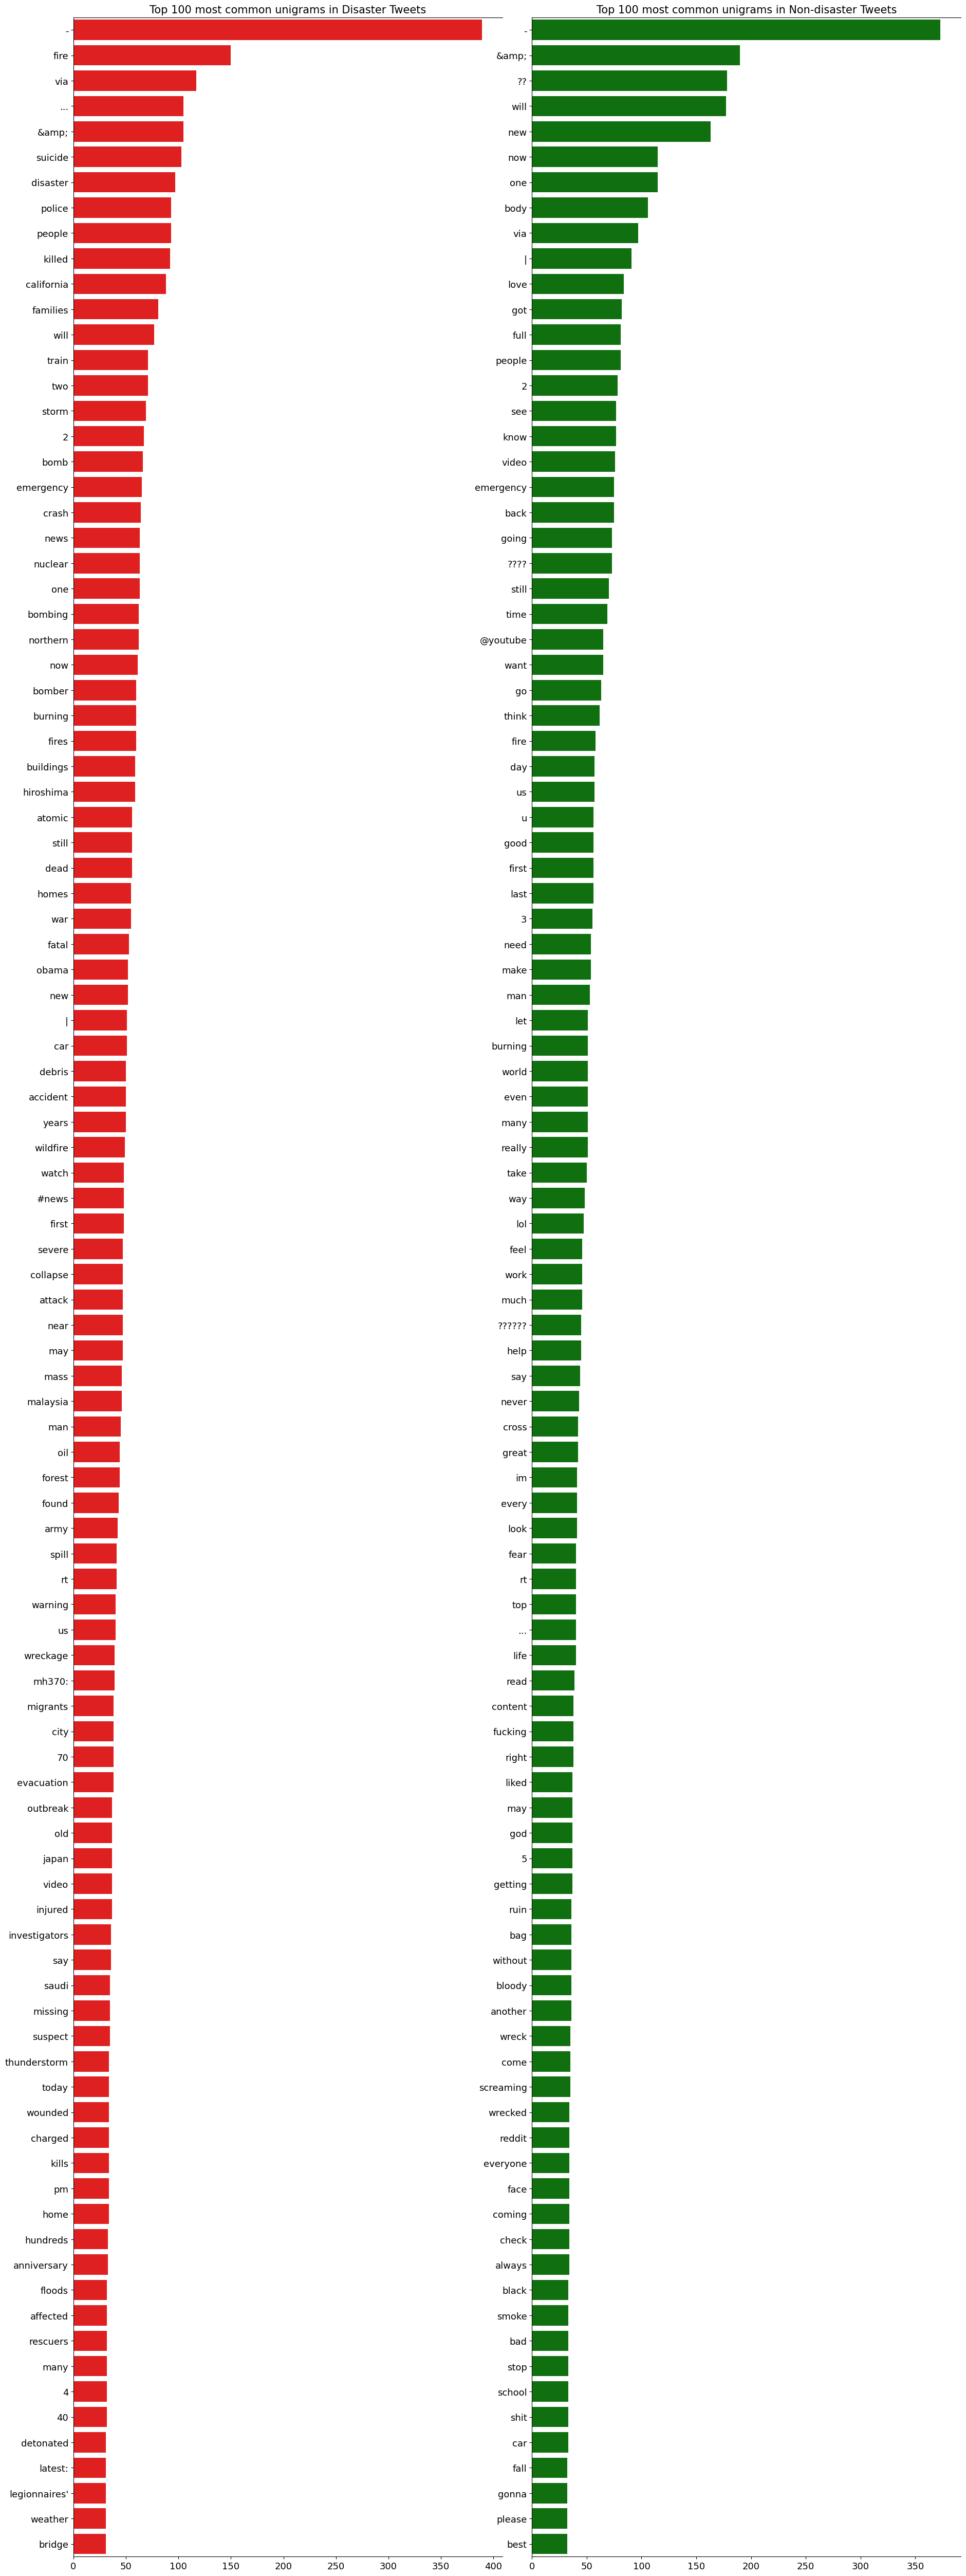

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

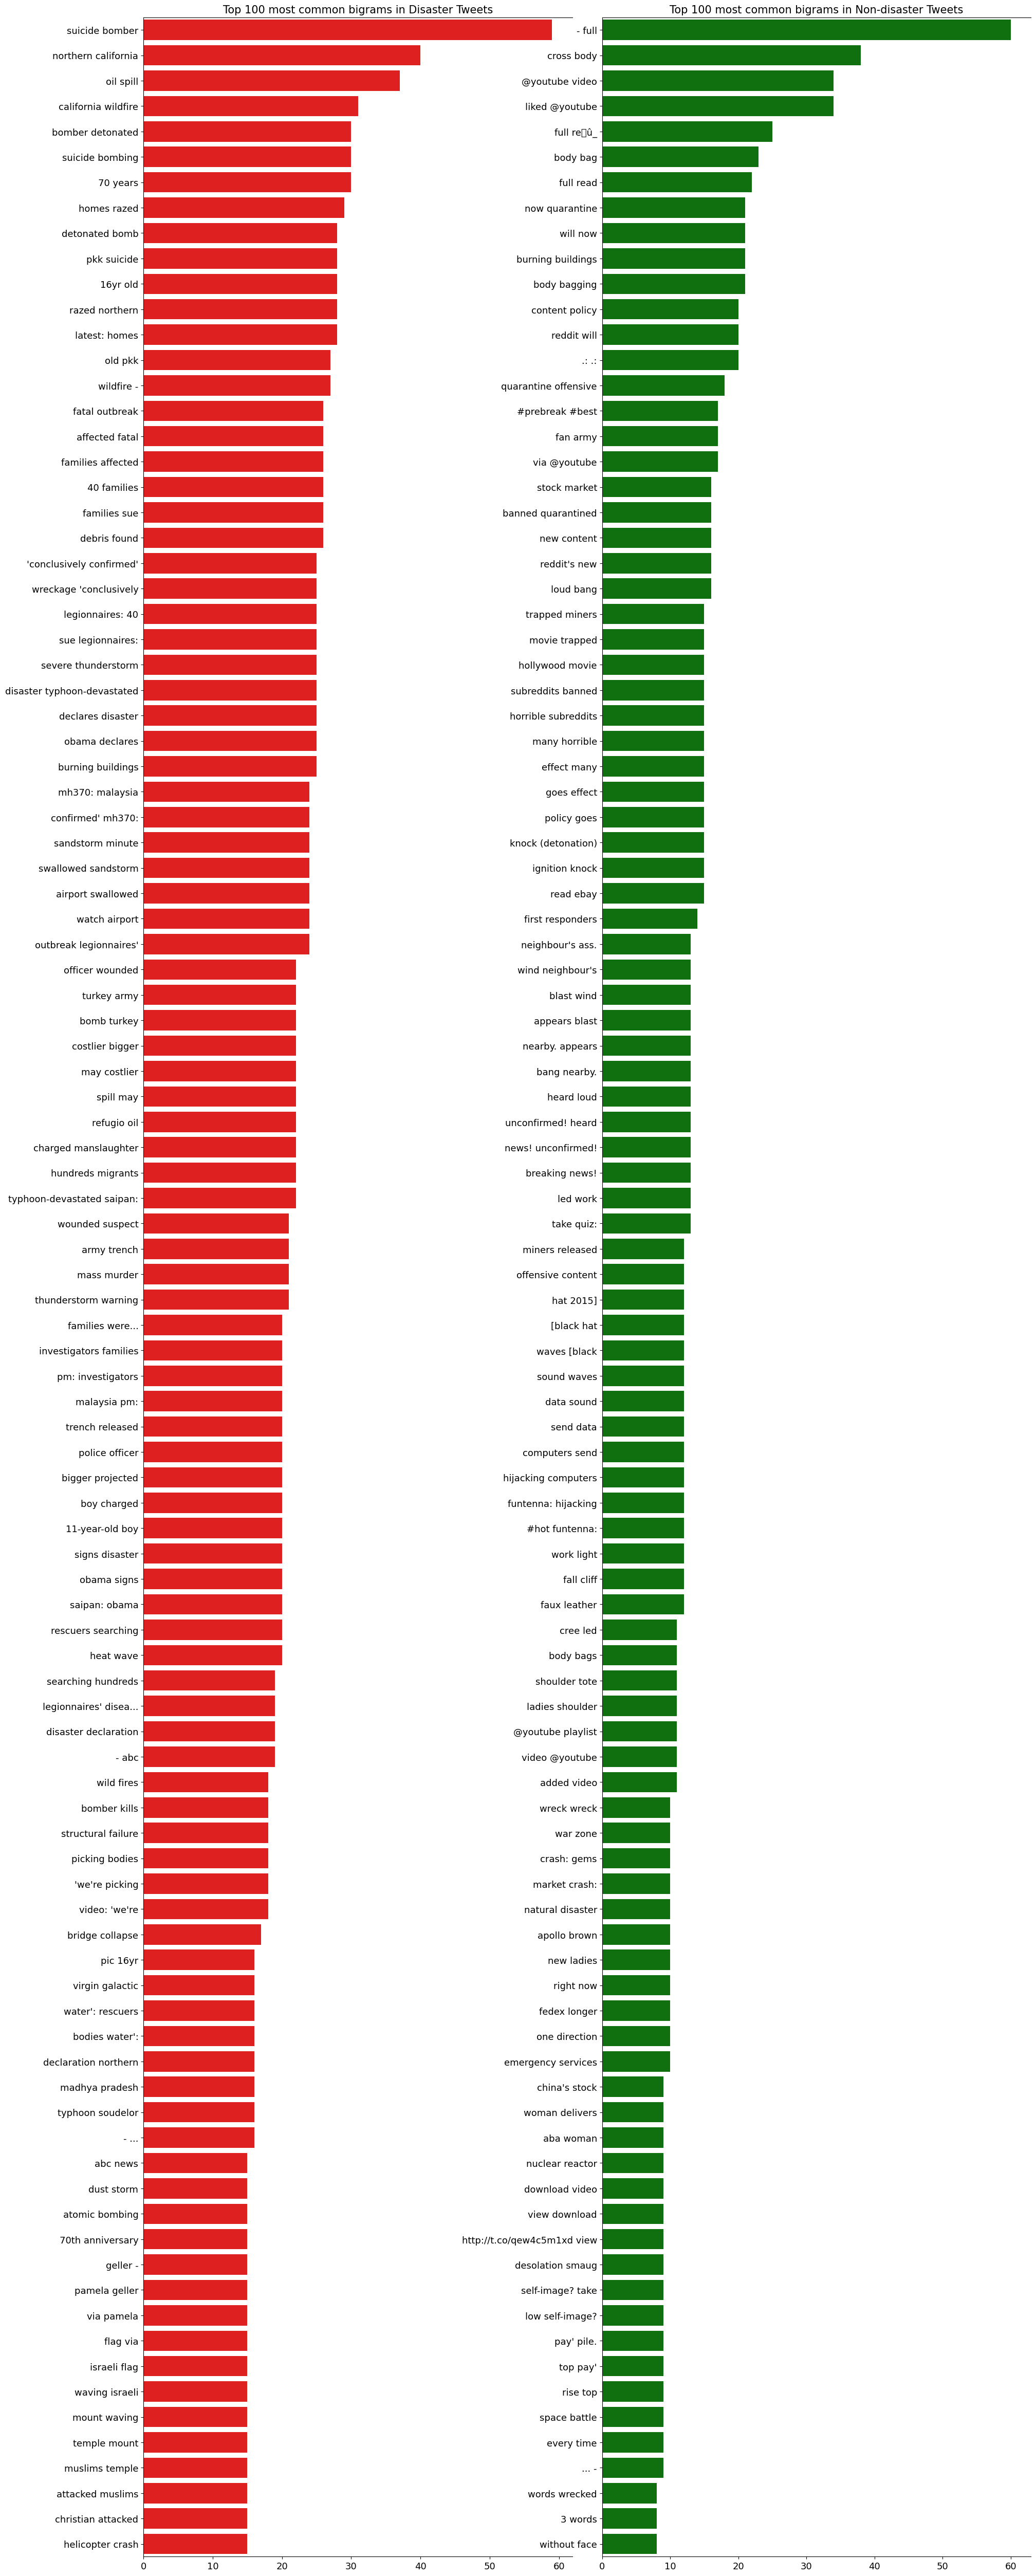

In [16]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 50), dpi=100)
plt.tight_layout()

sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

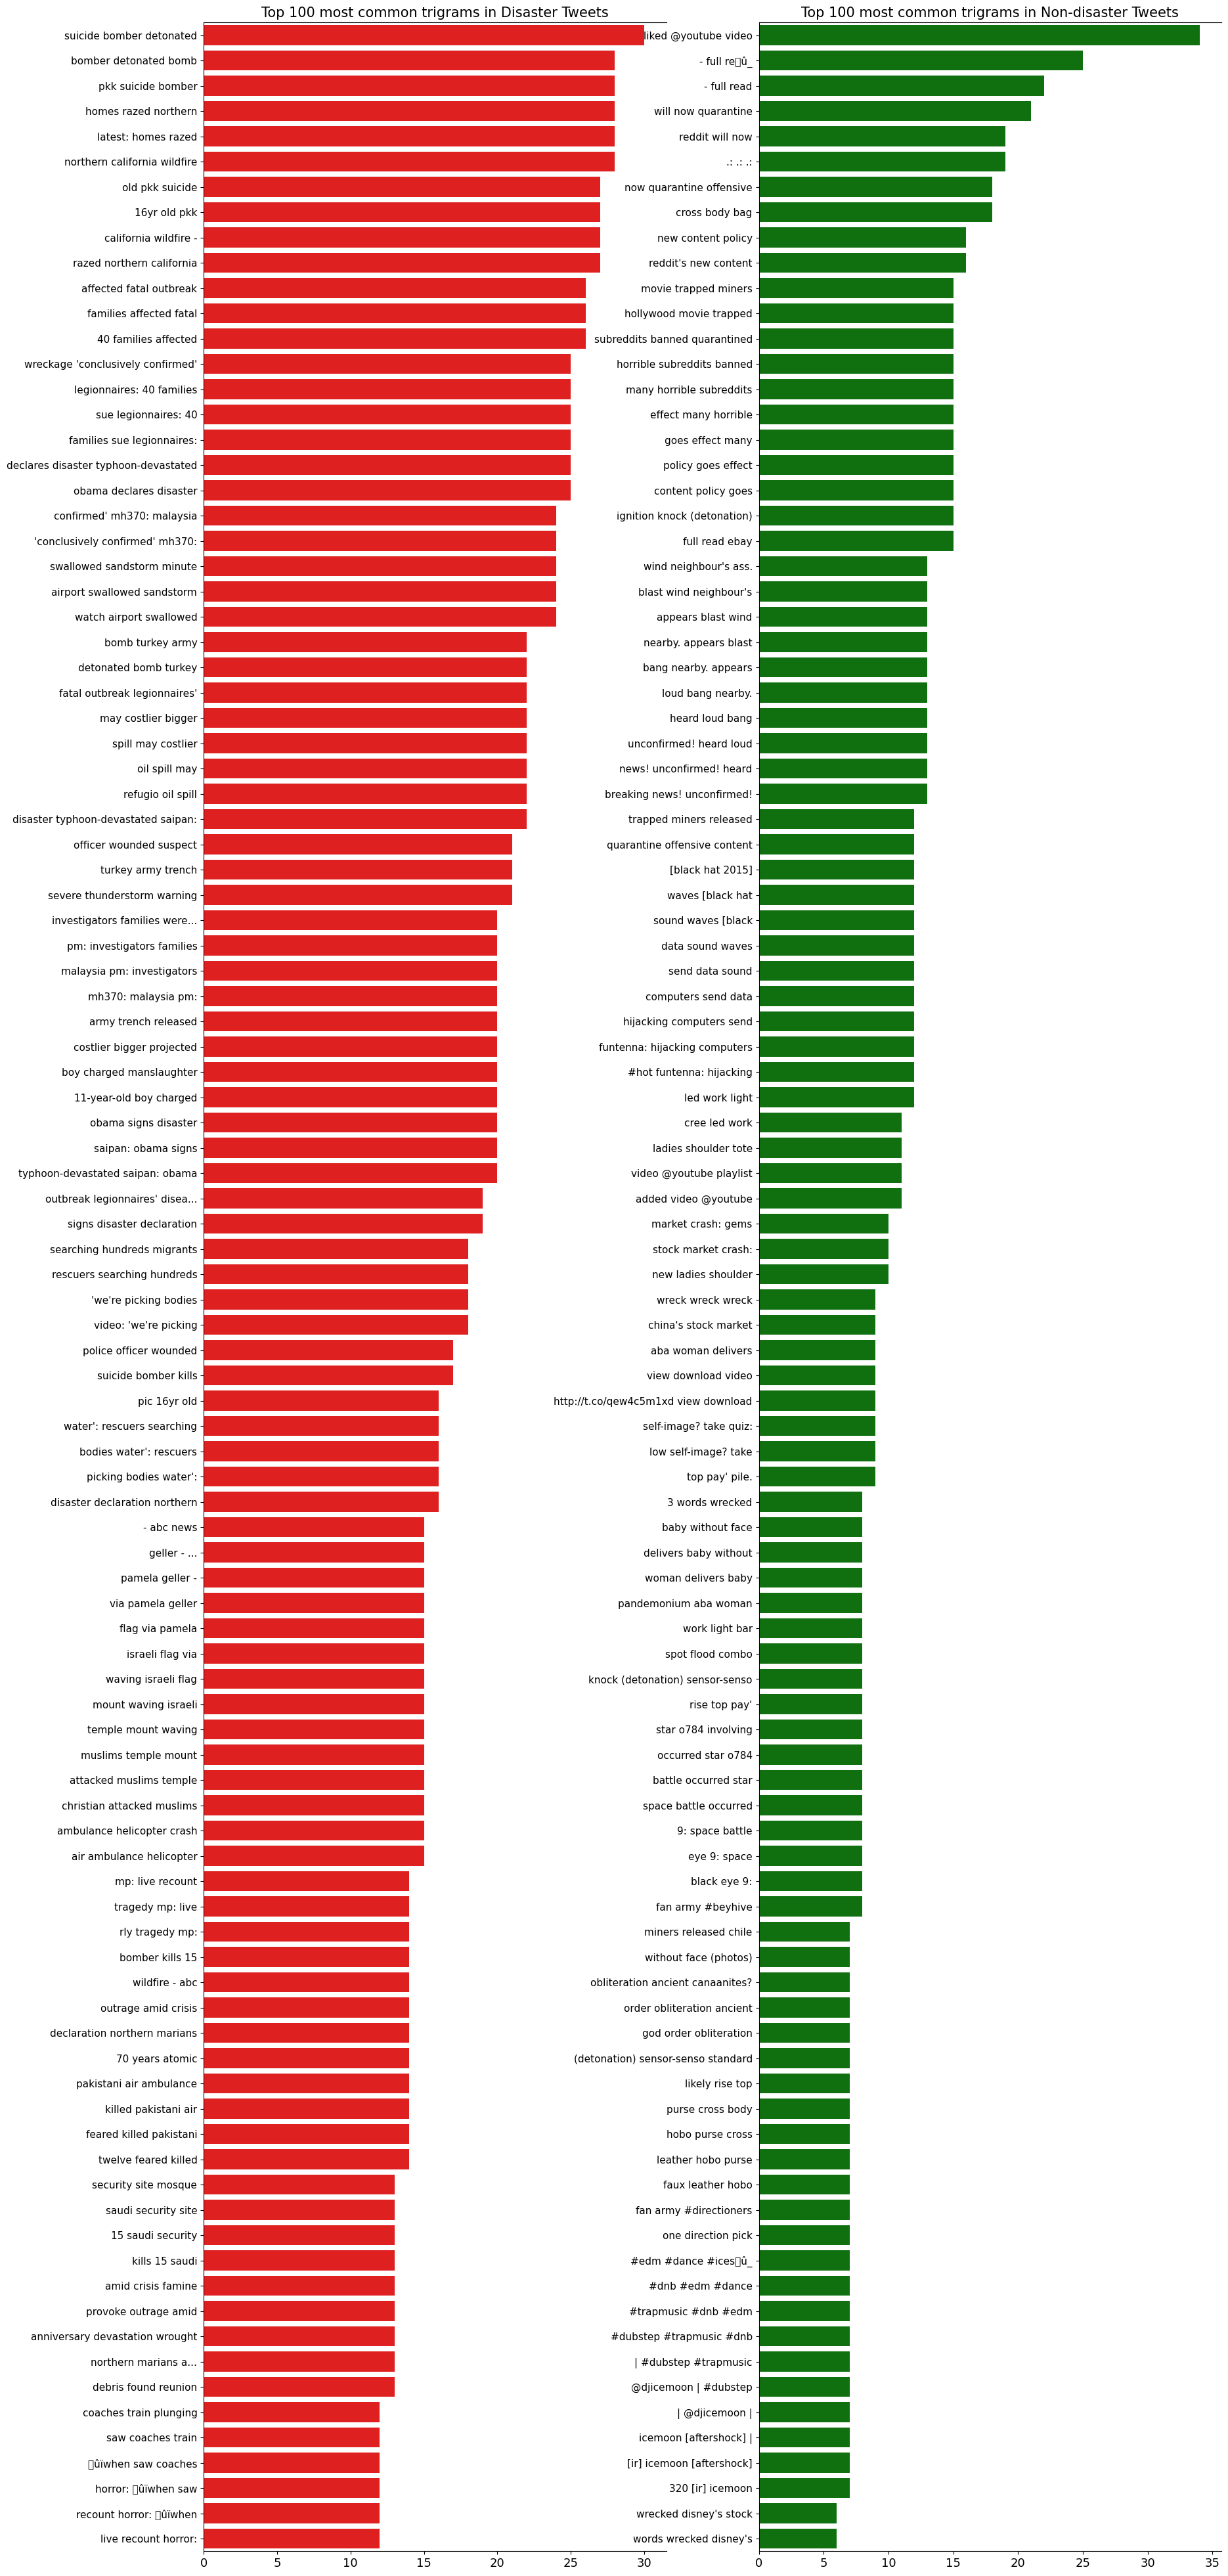

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 50), dpi=100)

sns.barplot(y=df_disaster_trigrams[0].values[:N], x=df_disaster_trigrams[1].values[:N], ax=axes[0], color='red')
sns.barplot(y=df_nondisaster_trigrams[0].values[:N], x=df_nondisaster_trigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=11)

axes[0].set_title(f'Top {N} most common trigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common trigrams in Non-disaster Tweets', fontsize=15)

plt.show()

From the unigrams, bigrams, and trigrams, we can see that both classes do not share similar words, with the disaster tweets having more context on disasters. 

In [19]:
# glove_embeddings = np.load('../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl', allow_pickle=True)
# fasttext_embeddings = np.load('../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl', allow_pickle=True)

In [20]:
# def build_vocab(X):
    
#     tweets = X.apply(lambda s: s.split()).values      
#     vocab = {}
    
#     for tweet in tweets:
#         for word in tweet:
#             try:
#                 vocab[word] += 1
#             except KeyError:
#                 vocab[word] = 1                
#     return vocab


# def check_embeddings_coverage(X, embeddings):
    
#     vocab = build_vocab(X)    
    
#     covered = {}
#     oov = {}    
#     n_covered = 0
#     n_oov = 0
    
#     for word in vocab:
#         try:
#             covered[word] = embeddings[word]
#             n_covered += vocab[word]
#         except:
#             oov[word] = vocab[word]
#             n_oov += vocab[word]
            
#     vocab_coverage = len(covered) / len(vocab)
#     text_coverage = (n_covered / (n_covered + n_oov))
    
#     sorted_oov = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
#     return sorted_oov, vocab_coverage, text_coverage

# train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text'], glove_embeddings)
# test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text'], glove_embeddings)
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

# train_fasttext_oov, train_fasttext_vocab_coverage, train_fasttext_text_coverage = check_embeddings_coverage(df_train['text'], fasttext_embeddings)
# test_fasttext_oov, test_fasttext_vocab_coverage, test_fasttext_text_coverage = check_embeddings_coverage(df_test['text'], fasttext_embeddings)
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_fasttext_vocab_coverage, train_fasttext_text_coverage))
# print('FastText Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_fasttext_vocab_coverage, test_fasttext_text_coverage))

GloVe Embeddings cover 52.06% of vocabulary and 82.68% of text in Training Set\
GloVe Embeddings cover 57.21% of vocabulary and 81.85% of text in Test Set\
FastText Embeddings cover 51.52% of vocabulary and 81.84% of text in Training Set\
FastText Embeddings cover 56.55% of vocabulary and 81.12% of text in Test Set

In [ ]:
# del fasttext_embeddings, train_fasttext_oov, test_fasttext_oov

GloVe embeddings will be used since it has slightly higher coverage. 

Taking Gunes Evitan's code for cleaning based on the words that were not covered by GloVe. 

- The most common type of words that require cleaning in oov have punctuations at the start or end. Those words doesn't have embeddings because of the trailing punctuations. Punctuations #, @, !, ?, +, &, -, $, =, <, >, |, {, }, ^, ', (, ),[, ], *, %, ..., ', ., :, ; are separated from words

- Special characters that are attached to words are removed completely
- Contractions are expanded
- Urls are removed
- Character entity references are replaced with their actual symbols
- Typos and slang are corrected, and informal abbreviations are written in their long forms
- Some words are replaced with their acronyms and some words are grouped into one
- Finally, hashtags and usernames contain lots of information about the context but they are written without spaces in between words so they don't have embeddings. Informational usernames and hashtags should be expanded but there are too many of them. I expanded as many as I could, but it takes too much time to run clean function after adding those replace calls.


In [ ]:
# def clean(tweet): 
            
#     # Special characters
#     tweet = re.sub(r"\x89Û_", "", tweet)
#     tweet = re.sub(r"\x89ÛÒ", "", tweet)
#     tweet = re.sub(r"\x89ÛÓ", "", tweet)
#     tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
#     tweet = re.sub(r"\x89ÛÏ", "", tweet)
#     tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
#     tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
#     tweet = re.sub(r"\x89Û÷", "", tweet)
#     tweet = re.sub(r"\x89Ûª", "", tweet)
#     tweet = re.sub(r"\x89Û\x9d", "", tweet)
#     tweet = re.sub(r"å_", "", tweet)
#     tweet = re.sub(r"\x89Û¢", "", tweet)
#     tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
#     tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
#     tweet = re.sub(r"åÊ", "", tweet)
#     tweet = re.sub(r"åÈ", "", tweet)
#     tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
#     tweet = re.sub(r"Ì©", "e", tweet)
#     tweet = re.sub(r"å¨", "", tweet)
#     tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
#     tweet = re.sub(r"åÇ", "", tweet)
#     tweet = re.sub(r"å£3million", "3 million", tweet)
#     tweet = re.sub(r"åÀ", "", tweet)
    
#     # Contractions
#     tweet = re.sub(r"he's", "he is", tweet)
#     tweet = re.sub(r"there's", "there is", tweet)
#     tweet = re.sub(r"We're", "We are", tweet)
#     tweet = re.sub(r"That's", "That is", tweet)
#     tweet = re.sub(r"won't", "will not", tweet)
#     tweet = re.sub(r"they're", "they are", tweet)
#     tweet = re.sub(r"Can't", "Cannot", tweet)
#     tweet = re.sub(r"wasn't", "was not", tweet)
#     tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
#     tweet = re.sub(r"aren't", "are not", tweet)
#     tweet = re.sub(r"isn't", "is not", tweet)
#     tweet = re.sub(r"What's", "What is", tweet)
#     tweet = re.sub(r"haven't", "have not", tweet)
#     tweet = re.sub(r"hasn't", "has not", tweet)
#     tweet = re.sub(r"There's", "There is", tweet)
#     tweet = re.sub(r"He's", "He is", tweet)
#     tweet = re.sub(r"It's", "It is", tweet)
#     tweet = re.sub(r"You're", "You are", tweet)
#     tweet = re.sub(r"I'M", "I am", tweet)
#     tweet = re.sub(r"shouldn't", "should not", tweet)
#     tweet = re.sub(r"wouldn't", "would not", tweet)
#     tweet = re.sub(r"i'm", "I am", tweet)
#     tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
#     tweet = re.sub(r"I'm", "I am", tweet)
#     tweet = re.sub(r"Isn't", "is not", tweet)
#     tweet = re.sub(r"Here's", "Here is", tweet)
#     tweet = re.sub(r"you've", "you have", tweet)
#     tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
#     tweet = re.sub(r"we're", "we are", tweet)
#     tweet = re.sub(r"what's", "what is", tweet)
#     tweet = re.sub(r"couldn't", "could not", tweet)
#     tweet = re.sub(r"we've", "we have", tweet)
#     tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
#     tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
#     tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
#     tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
#     tweet = re.sub(r"who's", "who is", tweet)
#     tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
#     tweet = re.sub(r"y'all", "you all", tweet)
#     tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
#     tweet = re.sub(r"would've", "would have", tweet)
#     tweet = re.sub(r"it'll", "it will", tweet)
#     tweet = re.sub(r"we'll", "we will", tweet)
#     tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
#     tweet = re.sub(r"We've", "We have", tweet)
#     tweet = re.sub(r"he'll", "he will", tweet)
#     tweet = re.sub(r"Y'all", "You all", tweet)
#     tweet = re.sub(r"Weren't", "Were not", tweet)
#     tweet = re.sub(r"Didn't", "Did not", tweet)
#     tweet = re.sub(r"they'll", "they will", tweet)
#     tweet = re.sub(r"they'd", "they would", tweet)
#     tweet = re.sub(r"DON'T", "DO NOT", tweet)
#     tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
#     tweet = re.sub(r"they've", "they have", tweet)
#     tweet = re.sub(r"i'd", "I would", tweet)
#     tweet = re.sub(r"should've", "should have", tweet)
#     tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
#     tweet = re.sub(r"where's", "where is", tweet)
#     tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
#     tweet = re.sub(r"we'd", "we would", tweet)
#     tweet = re.sub(r"i'll", "I will", tweet)
#     tweet = re.sub(r"weren't", "were not", tweet)
#     tweet = re.sub(r"They're", "They are", tweet)
#     tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
#     tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
#     tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
#     tweet = re.sub(r"let's", "let us", tweet)
#     tweet = re.sub(r"it's", "it is", tweet)
#     tweet = re.sub(r"can't", "cannot", tweet)
#     tweet = re.sub(r"don't", "do not", tweet)
#     tweet = re.sub(r"you're", "you are", tweet)
#     tweet = re.sub(r"i've", "I have", tweet)
#     tweet = re.sub(r"that's", "that is", tweet)
#     tweet = re.sub(r"i'll", "I will", tweet)
#     tweet = re.sub(r"doesn't", "does not", tweet)
#     tweet = re.sub(r"i'd", "I would", tweet)
#     tweet = re.sub(r"didn't", "did not", tweet)
#     tweet = re.sub(r"ain't", "am not", tweet)
#     tweet = re.sub(r"you'll", "you will", tweet)
#     tweet = re.sub(r"I've", "I have", tweet)
#     tweet = re.sub(r"Don't", "do not", tweet)
#     tweet = re.sub(r"I'll", "I will", tweet)
#     tweet = re.sub(r"I'd", "I would", tweet)
#     tweet = re.sub(r"Let's", "Let us", tweet)
#     tweet = re.sub(r"you'd", "You would", tweet)
#     tweet = re.sub(r"It's", "It is", tweet)
#     tweet = re.sub(r"Ain't", "am not", tweet)
#     tweet = re.sub(r"Haven't", "Have not", tweet)
#     tweet = re.sub(r"Could've", "Could have", tweet)
#     tweet = re.sub(r"youve", "you have", tweet)  
#     tweet = re.sub(r"donå«t", "do not", tweet)   
            
#     # Character entity references
#     tweet = re.sub(r"&gt;", ">", tweet)
#     tweet = re.sub(r"&lt;", "<", tweet)
#     tweet = re.sub(r"&amp;", "&", tweet)
    
#     # Typos, slang and informal abbreviations
#     tweet = re.sub(r"w/e", "whatever", tweet)
#     tweet = re.sub(r"w/", "with", tweet)
#     tweet = re.sub(r"USAgov", "USA government", tweet)
#     tweet = re.sub(r"recentlu", "recently", tweet)
#     tweet = re.sub(r"Ph0tos", "Photos", tweet)
#     tweet = re.sub(r"amirite", "am I right", tweet)
#     tweet = re.sub(r"exp0sed", "exposed", tweet)
#     tweet = re.sub(r"<3", "love", tweet)
#     tweet = re.sub(r"amageddon", "armageddon", tweet)
#     tweet = re.sub(r"Trfc", "Traffic", tweet)
#     tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
#     tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
#     tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
#     tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
#     tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
#     tweet = re.sub(r"16yr", "16 year", tweet)
#     tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
#     tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
#     # Hashtags and usernames
#     tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
#     tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
#     tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
#     tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
#     tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
#     tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
#     tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
#     tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
#     tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
#     tweet = re.sub(r"socialnews", "social news", tweet)
#     tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
#     tweet = re.sub(r"onlinecommunities", "online communities", tweet)
#     tweet = re.sub(r"humanconsumption", "human consumption", tweet)
#     tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
#     tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
#     tweet = re.sub(r"facialabuse", "facial abuse", tweet)
#     tweet = re.sub(r"LakeCounty", "Lake County", tweet)
#     tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
#     tweet = re.sub(r"withheavenly", "with heavenly", tweet)
#     tweet = re.sub(r"thankU", "thank you", tweet)
#     tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
#     tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
#     tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
#     tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
#     tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
#     tweet = re.sub(r"animalrescue", "animal rescue", tweet)
#     tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
#     tweet = re.sub(r"aRmageddon", "armageddon", tweet)
#     tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
#     tweet = re.sub(r"GodsLove", "God's Love", tweet)
#     tweet = re.sub(r"bookboost", "book boost", tweet)
#     tweet = re.sub(r"ibooklove", "I book love", tweet)
#     tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
#     tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
#     tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
#     tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
#     tweet = re.sub(r"weathernetwork", "weather network", tweet)
#     tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
#     tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
#     tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
#     tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
#     tweet = re.sub(r"frontpage", "front page", tweet)
#     tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
#     tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
#     tweet = re.sub(r"til_now", "until now", tweet)
#     tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
#     tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
#     tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
#     tweet = re.sub(r"53inch", "53 inch", tweet)
#     tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
#     tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
#     tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
#     tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
#     tweet = re.sub(r"DETECTADO", "Detected", tweet)
#     tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
#     tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
#     tweet = re.sub(r"NickCannon", "Nick Cannon", tweet)
#     tweet = re.sub(r"FaroeIslands", "Faroe Islands", tweet)
#     tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
#     tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
#     tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
#     tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
#     tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
#     tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
#     tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
#     tweet = re.sub(r"Time2015", "Time 2015", tweet)
#     tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
#     tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
#     tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
#     tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
#     tweet = re.sub(r"bbcnews", "bbc news", tweet)
#     tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
#     tweet = re.sub(r"c4news", "c4 news", tweet)
#     tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
#     tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
#     tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
#     tweet = re.sub(r"NotExplained", "Not Explained", tweet)
#     tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
#     tweet = re.sub(r"LondonFire", "London Fire", tweet)
#     tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
#     tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
#     tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
#     tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
#     tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
#     tweet = re.sub(r"nikeplus", "nike plus", tweet)
#     tweet = re.sub(r"david_cameron", "David Cameron", tweet)
#     tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
#     tweet = re.sub(r"JamesMelville", "James Melville", tweet)
#     tweet = re.sub(r"megynkelly", "Megyn Kelly", tweet)
#     tweet = re.sub(r"cnewslive", "C News Live", tweet)
#     tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
#     tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
#     tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
#     tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
#     tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
#     tweet = re.sub(r"cjoyner", "Chris Joyner", tweet)
#     tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
#     tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)
#     tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
#     tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
#     tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
#     tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
#     tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
#     tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
#     tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
#     tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
#     tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
#     tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
#     tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
#     tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
#     tweet = re.sub(r"GRupdates", "GR updates", tweet)
#     tweet = re.sub(r"SouthDowns", "South Downs", tweet)
#     tweet = re.sub(r"braininjury", "brain injury", tweet)
#     tweet = re.sub(r"auspol", "Australian politics", tweet)
#     tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
#     tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
#     tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
#     tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
#     tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
#     tweet = re.sub(r"S3XLEAK", "sex leak", tweet)
#     tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
#     tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
#     tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
#     tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
#     tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
#     tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
#     tweet = re.sub(r"offers2go", "offers to go", tweet)
#     tweet = re.sub(r"foodscare", "food scare", tweet)
#     tweet = re.sub(r"MNPDNashville", "Metropolitan Nashville Police Department", tweet)
#     tweet = re.sub(r"TfLBusAlerts", "TfL Bus Alerts", tweet)
#     tweet = re.sub(r"GamerGate", "Gamer Gate", tweet)
#     tweet = re.sub(r"IHHen", "Humanitarian Relief", tweet)
#     tweet = re.sub(r"spinningbot", "spinning bot", tweet)
#     tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
#     tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
#     tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
#     tweet = re.sub(r"po_st", "po.st", tweet)
#     tweet = re.sub(r"scoopit", "scoop.it", tweet)
#     tweet = re.sub(r"UltimaLucha", "Ultima Lucha", tweet)
#     tweet = re.sub(r"JonathanFerrell", "Jonathan Ferrell", tweet)
#     tweet = re.sub(r"aria_ahrary", "Aria Ahrary", tweet)
#     tweet = re.sub(r"rapidcity", "Rapid City", tweet)
#     tweet = re.sub(r"OutBid", "outbid", tweet)
#     tweet = re.sub(r"lavenderpoetrycafe", "lavender poetry cafe", tweet)
#     tweet = re.sub(r"EudryLantiqua", "Eudry Lantiqua", tweet)
#     tweet = re.sub(r"15PM", "15 PM", tweet)
#     tweet = re.sub(r"OriginalFunko", "Funko", tweet)
#     tweet = re.sub(r"rightwaystan", "Richard Tan", tweet)
#     tweet = re.sub(r"CindyNoonan", "Cindy Noonan", tweet)
#     tweet = re.sub(r"RT_America", "RT America", tweet)
#     tweet = re.sub(r"narendramodi", "Narendra Modi", tweet)
#     tweet = re.sub(r"BakeOffFriends", "Bake Off Friends", tweet)
#     tweet = re.sub(r"TeamHendrick", "Hendrick Motorsports", tweet)
#     tweet = re.sub(r"alexbelloli", "Alex Belloli", tweet)
#     tweet = re.sub(r"itsjustinstuart", "Justin Stuart", tweet)
#     tweet = re.sub(r"gunsense", "gun sense", tweet)
#     tweet = re.sub(r"DebateQuestionsWeWantToHear", "debate questions we want to hear", tweet)
#     tweet = re.sub(r"RoyalCarribean", "Royal Carribean", tweet)
#     tweet = re.sub(r"samanthaturne19", "Samantha Turner", tweet)
#     tweet = re.sub(r"JonVoyage", "Jon Stewart", tweet)
#     tweet = re.sub(r"renew911health", "renew 911 health", tweet)
#     tweet = re.sub(r"SuryaRay", "Surya Ray", tweet)
#     tweet = re.sub(r"pattonoswalt", "Patton Oswalt", tweet)
#     tweet = re.sub(r"minhazmerchant", "Minhaz Merchant", tweet)
#     tweet = re.sub(r"TLVFaces", "Israel Diaspora Coalition", tweet)
#     tweet = re.sub(r"pmarca", "Marc Andreessen", tweet)
#     tweet = re.sub(r"pdx911", "Portland Police", tweet)
#     tweet = re.sub(r"jamaicaplain", "Jamaica Plain", tweet)
#     tweet = re.sub(r"Japton", "Arkansas", tweet)
#     tweet = re.sub(r"RouteComplex", "Route Complex", tweet)
#     tweet = re.sub(r"INSubcontinent", "Indian Subcontinent", tweet)
#     tweet = re.sub(r"NJTurnpike", "New Jersey Turnpike", tweet)
#     tweet = re.sub(r"Politifiact", "PolitiFact", tweet)
#     tweet = re.sub(r"Hiroshima70", "Hiroshima", tweet)
#     tweet = re.sub(r"GMMBC", "Greater Mt Moriah Baptist Church", tweet)
#     tweet = re.sub(r"versethe", "verse the", tweet)
#     tweet = re.sub(r"TubeStrike", "Tube Strike", tweet)
#     tweet = re.sub(r"MissionHills", "Mission Hills", tweet)
#     tweet = re.sub(r"ProtectDenaliWolves", "Protect Denali Wolves", tweet)
#     tweet = re.sub(r"NANKANA", "Nankana", tweet)
#     tweet = re.sub(r"SAHIB", "Sahib", tweet)
#     tweet = re.sub(r"PAKPATTAN", "Pakpattan", tweet)
#     tweet = re.sub(r"Newz_Sacramento", "News Sacramento", tweet)
#     tweet = re.sub(r"gofundme", "go fund me", tweet)
#     tweet = re.sub(r"pmharper", "Stephen Harper", tweet)
#     tweet = re.sub(r"IvanBerroa", "Ivan Berroa", tweet)
#     tweet = re.sub(r"LosDelSonido", "Los Del Sonido", tweet)
#     tweet = re.sub(r"bancodeseries", "banco de series", tweet)
#     tweet = re.sub(r"timkaine", "Tim Kaine", tweet)
#     tweet = re.sub(r"IdentityTheft", "Identity Theft", tweet)
#     tweet = re.sub(r"AllLivesMatter", "All Lives Matter", tweet)
#     tweet = re.sub(r"mishacollins", "Misha Collins", tweet)
#     tweet = re.sub(r"BillNeelyNBC", "Bill Neely", tweet)
#     tweet = re.sub(r"BeClearOnCancer", "be clear on cancer", tweet)
#     tweet = re.sub(r"Kowing", "Knowing", tweet)
#     tweet = re.sub(r"ScreamQueens", "Scream Queens", tweet)
#     tweet = re.sub(r"AskCharley", "Ask Charley", tweet)
#     tweet = re.sub(r"BlizzHeroes", "Heroes of the Storm", tweet)
#     tweet = re.sub(r"BradleyBrad47", "Bradley Brad", tweet)
#     tweet = re.sub(r"HannaPH", "Typhoon Hanna", tweet)
#     tweet = re.sub(r"meinlcymbals", "MEINL Cymbals", tweet)
#     tweet = re.sub(r"Ptbo", "Peterborough", tweet)
#     tweet = re.sub(r"cnnbrk", "CNN Breaking News", tweet)
#     tweet = re.sub(r"IndianNews", "Indian News", tweet)
#     tweet = re.sub(r"savebees", "save bees", tweet)
#     tweet = re.sub(r"GreenHarvard", "Green Harvard", tweet)
#     tweet = re.sub(r"StandwithPP", "Stand with planned parenthood", tweet)
#     tweet = re.sub(r"hermancranston", "Herman Cranston", tweet)
#     tweet = re.sub(r"WMUR9", "WMUR-TV", tweet)
#     tweet = re.sub(r"RockBottomRadFM", "Rock Bottom Radio", tweet)
#     tweet = re.sub(r"ameenshaikh3", "Ameen Shaikh", tweet)
#     tweet = re.sub(r"ProSyn", "Project Syndicate", tweet)
#     tweet = re.sub(r"Daesh", "ISIS", tweet)
#     tweet = re.sub(r"s2g", "swear to god", tweet)
#     tweet = re.sub(r"listenlive", "listen live", tweet)
#     tweet = re.sub(r"CDCgov", "Centers for Disease Control and Prevention", tweet)
#     tweet = re.sub(r"FoxNew", "Fox News", tweet)
#     tweet = re.sub(r"CBSBigBrother", "Big Brother", tweet)
#     tweet = re.sub(r"JulieDiCaro", "Julie DiCaro", tweet)
#     tweet = re.sub(r"theadvocatemag", "The Advocate Magazine", tweet)
#     tweet = re.sub(r"RohnertParkDPS", "Rohnert Park Police Department", tweet)
#     tweet = re.sub(r"THISIZBWRIGHT", "Bonnie Wright", tweet)
#     tweet = re.sub(r"Popularmmos", "Popular MMOs", tweet)
#     tweet = re.sub(r"WildHorses", "Wild Horses", tweet)
#     tweet = re.sub(r"FantasticFour", "Fantastic Four", tweet)
#     tweet = re.sub(r"HORNDALE", "Horndale", tweet)
#     tweet = re.sub(r"PINER", "Piner", tweet)
#     tweet = re.sub(r"BathAndNorthEastSomerset", "Bath and North East Somerset", tweet)
#     tweet = re.sub(r"thatswhatfriendsarefor", "that is what friends are for", tweet)
#     tweet = re.sub(r"residualincome", "residual income", tweet)
#     tweet = re.sub(r"YahooNewsDigest", "Yahoo News Digest", tweet)
#     tweet = re.sub(r"MalaysiaAirlines", "Malaysia Airlines", tweet)
#     tweet = re.sub(r"AmazonDeals", "Amazon Deals", tweet)
#     tweet = re.sub(r"MissCharleyWebb", "Charley Webb", tweet)
#     tweet = re.sub(r"shoalstraffic", "shoals traffic", tweet)
#     tweet = re.sub(r"GeorgeFoster72", "George Foster", tweet)
#     tweet = re.sub(r"pop2015", "pop 2015", tweet)
#     tweet = re.sub(r"_PokemonCards_", "Pokemon Cards", tweet)
#     tweet = re.sub(r"DianneG", "Dianne Gallagher", tweet)
#     tweet = re.sub(r"KashmirConflict", "Kashmir Conflict", tweet)
#     tweet = re.sub(r"BritishBakeOff", "British Bake Off", tweet)
#     tweet = re.sub(r"FreeKashmir", "Free Kashmir", tweet)
#     tweet = re.sub(r"mattmosley", "Matt Mosley", tweet)
#     tweet = re.sub(r"BishopFred", "Bishop Fred", tweet)
#     tweet = re.sub(r"EndConflict", "End Conflict", tweet)
#     tweet = re.sub(r"EndOccupation", "End Occupation", tweet)
#     tweet = re.sub(r"UNHEALED", "unhealed", tweet)
#     tweet = re.sub(r"CharlesDagnall", "Charles Dagnall", tweet)
#     tweet = re.sub(r"Latestnews", "Latest news", tweet)
#     tweet = re.sub(r"KindleCountdown", "Kindle Countdown", tweet)
#     tweet = re.sub(r"NoMoreHandouts", "No More Handouts", tweet)
#     tweet = re.sub(r"datingtips", "dating tips", tweet)
#     tweet = re.sub(r"charlesadler", "Charles Adler", tweet)
#     tweet = re.sub(r"twia", "Texas Windstorm Insurance Association", tweet)
#     tweet = re.sub(r"txlege", "Texas Legislature", tweet)
#     tweet = re.sub(r"WindstormInsurer", "Windstorm Insurer", tweet)
#     tweet = re.sub(r"Newss", "News", tweet)
#     tweet = re.sub(r"hempoil", "hemp oil", tweet)
#     tweet = re.sub(r"CommoditiesAre", "Commodities are", tweet)
#     tweet = re.sub(r"tubestrike", "tube strike", tweet)
#     tweet = re.sub(r"JoeNBC", "Joe Scarborough", tweet)
#     tweet = re.sub(r"LiteraryCakes", "Literary Cakes", tweet)
#     tweet = re.sub(r"TI5", "The International 5", tweet)
#     tweet = re.sub(r"thehill", "the hill", tweet)
#     tweet = re.sub(r"3others", "3 others", tweet)
#     tweet = re.sub(r"stighefootball", "Sam Tighe", tweet)
#     tweet = re.sub(r"whatstheimportantvideo", "what is the important video", tweet)
#     tweet = re.sub(r"ClaudioMeloni", "Claudio Meloni", tweet)
#     tweet = re.sub(r"DukeSkywalker", "Duke Skywalker", tweet)
#     tweet = re.sub(r"carsonmwr", "Fort Carson", tweet)
#     tweet = re.sub(r"offdishduty", "off dish duty", tweet)
#     tweet = re.sub(r"andword", "and word", tweet)
#     tweet = re.sub(r"rhodeisland", "Rhode Island", tweet)
#     tweet = re.sub(r"easternoregon", "Eastern Oregon", tweet)
#     tweet = re.sub(r"WAwildfire", "Washington Wildfire", tweet)
#     tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
#     tweet = re.sub(r"57am", "57 am", tweet)
#     tweet = re.sub(r"fingerrockfire", "Finger Rock Fire", tweet)
#     tweet = re.sub(r"JacobHoggard", "Jacob Hoggard", tweet)
#     tweet = re.sub(r"newnewnew", "new new new", tweet)
#     tweet = re.sub(r"under50", "under 50", tweet)
#     tweet = re.sub(r"getitbeforeitsgone", "get it before it is gone", tweet)
#     tweet = re.sub(r"freshoutofthebox", "fresh out of the box", tweet)
#     tweet = re.sub(r"amwriting", "am writing", tweet)
#     tweet = re.sub(r"Bokoharm", "Boko Haram", tweet)
#     tweet = re.sub(r"Nowlike", "Now like", tweet)
#     tweet = re.sub(r"seasonfrom", "season from", tweet)
#     tweet = re.sub(r"epicente", "epicenter", tweet)
#     tweet = re.sub(r"epicenterr", "epicenter", tweet)
#     tweet = re.sub(r"sicklife", "sick life", tweet)
#     tweet = re.sub(r"yycweather", "Calgary Weather", tweet)
#     tweet = re.sub(r"calgarysun", "Calgary Sun", tweet)
#     tweet = re.sub(r"approachng", "approaching", tweet)
#     tweet = re.sub(r"evng", "evening", tweet)
#     tweet = re.sub(r"Sumthng", "something", tweet)
#     tweet = re.sub(r"EllenPompeo", "Ellen Pompeo", tweet)
#     tweet = re.sub(r"shondarhimes", "Shonda Rhimes", tweet)
#     tweet = re.sub(r"ABCNetwork", "ABC Network", tweet)
#     tweet = re.sub(r"SushmaSwaraj", "Sushma Swaraj", tweet)
#     tweet = re.sub(r"pray4japan", "Pray for Japan", tweet)
#     tweet = re.sub(r"hope4japan", "Hope for Japan", tweet)
#     tweet = re.sub(r"Illusionimagess", "Illusion images", tweet)
#     tweet = re.sub(r"SummerUnderTheStars", "Summer Under The Stars", tweet)
#     tweet = re.sub(r"ShallWeDance", "Shall We Dance", tweet)
#     tweet = re.sub(r"TCMParty", "TCM Party", tweet)
#     tweet = re.sub(r"marijuananews", "marijuana news", tweet)
#     tweet = re.sub(r"onbeingwithKristaTippett", "on being with Krista Tippett", tweet)
#     tweet = re.sub(r"Beingtweets", "Being tweets", tweet)
#     tweet = re.sub(r"newauthors", "new authors", tweet)
#     tweet = re.sub(r"remedyyyy", "remedy", tweet)
#     tweet = re.sub(r"44PM", "44 PM", tweet)
#     tweet = re.sub(r"HeadlinesApp", "Headlines App", tweet)
#     tweet = re.sub(r"40PM", "40 PM", tweet)
#     tweet = re.sub(r"myswc", "Severe Weather Center", tweet)
#     tweet = re.sub(r"ithats", "that is", tweet)
#     tweet = re.sub(r"icouldsitinthismomentforever", "I could sit in this moment forever", tweet)
#     tweet = re.sub(r"FatLoss", "Fat Loss", tweet)
#     tweet = re.sub(r"02PM", "02 PM", tweet)
#     tweet = re.sub(r"MetroFmTalk", "Metro Fm Talk", tweet)
#     tweet = re.sub(r"Bstrd", "bastard", tweet)
#     tweet = re.sub(r"bldy", "bloody", tweet)
#     tweet = re.sub(r"MetrofmTalk", "Metro Fm Talk", tweet)
#     tweet = re.sub(r"terrorismturn", "terrorism turn", tweet)
#     tweet = re.sub(r"BBCNewsAsia", "BBC News Asia", tweet)
#     tweet = re.sub(r"BehindTheScenes", "Behind The Scenes", tweet)
#     tweet = re.sub(r"GeorgeTakei", "George Takei", tweet)
#     tweet = re.sub(r"WomensWeeklyMag", "Womens Weekly Magazine", tweet)
#     tweet = re.sub(r"SurvivorsGuidetoEarth", "Survivors Guide to Earth", tweet)
#     tweet = re.sub(r"incubusband", "incubus band", tweet)
#     tweet = re.sub(r"Babypicturethis", "Baby picture this", tweet)
#     tweet = re.sub(r"BombEffects", "Bomb Effects", tweet)
#     tweet = re.sub(r"win10", "Windows 10", tweet)
#     tweet = re.sub(r"idkidk", "I do not know I do not know", tweet)
#     tweet = re.sub(r"TheWalkingDead", "The Walking Dead", tweet)
#     tweet = re.sub(r"amyschumer", "Amy Schumer", tweet)
#     tweet = re.sub(r"crewlist", "crew list", tweet)
#     tweet = re.sub(r"Erdogans", "Erdogan", tweet)
#     tweet = re.sub(r"BBCLive", "BBC Live", tweet)
#     tweet = re.sub(r"TonyAbbottMHR", "Tony Abbott", tweet)
#     tweet = re.sub(r"paulmyerscough", "Paul Myerscough", tweet)
#     tweet = re.sub(r"georgegallagher", "George Gallagher", tweet)
#     tweet = re.sub(r"JimmieJohnson", "Jimmie Johnson", tweet)
#     tweet = re.sub(r"pctool", "pc tool", tweet)
#     tweet = re.sub(r"DoingHashtagsRight", "Doing Hashtags Right", tweet)
#     tweet = re.sub(r"ThrowbackThursday", "Throwback Thursday", tweet)
#     tweet = re.sub(r"SnowBackSunday", "Snowback Sunday", tweet)
#     tweet = re.sub(r"LakeEffect", "Lake Effect", tweet)
#     tweet = re.sub(r"RTphotographyUK", "Richard Thomas Photography UK", tweet)
#     tweet = re.sub(r"BigBang_CBS", "Big Bang CBS", tweet)
#     tweet = re.sub(r"writerslife", "writers life", tweet)
#     tweet = re.sub(r"NaturalBirth", "Natural Birth", tweet)
#     tweet = re.sub(r"UnusualWords", "Unusual Words", tweet)
#     tweet = re.sub(r"wizkhalifa", "Wiz Khalifa", tweet)
#     tweet = re.sub(r"acreativedc", "a creative DC", tweet)
#     tweet = re.sub(r"vscodc", "vsco DC", tweet)
#     tweet = re.sub(r"VSCOcam", "vsco camera", tweet)
#     tweet = re.sub(r"TheBEACHDC", "The beach DC", tweet)
#     tweet = re.sub(r"buildingmuseum", "building museum", tweet)
#     tweet = re.sub(r"WorldOil", "World Oil", tweet)
#     tweet = re.sub(r"redwedding", "red wedding", tweet)
#     tweet = re.sub(r"AmazingRaceCanada", "Amazing Race Canada", tweet)
#     tweet = re.sub(r"WakeUpAmerica", "Wake Up America", tweet)
#     tweet = re.sub(r"\\Allahuakbar\\", "Allahu Akbar", tweet)
#     tweet = re.sub(r"bleased", "blessed", tweet)
#     tweet = re.sub(r"nigeriantribune", "Nigerian Tribune", tweet)
#     tweet = re.sub(r"HIDEO_KOJIMA_EN", "Hideo Kojima", tweet)
#     tweet = re.sub(r"FusionFestival", "Fusion Festival", tweet)
#     tweet = re.sub(r"50Mixed", "50 Mixed", tweet)
#     tweet = re.sub(r"NoAgenda", "No Agenda", tweet)
#     tweet = re.sub(r"WhiteGenocide", "White Genocide", tweet)
#     tweet = re.sub(r"dirtylying", "dirty lying", tweet)
#     tweet = re.sub(r"SyrianRefugees", "Syrian Refugees", tweet)
#     tweet = re.sub(r"changetheworld", "change the world", tweet)
#     tweet = re.sub(r"Ebolacase", "Ebola case", tweet)
#     tweet = re.sub(r"mcgtech", "mcg technologies", tweet)
#     tweet = re.sub(r"withweapons", "with weapons", tweet)
#     tweet = re.sub(r"advancedwarfare", "advanced warfare", tweet)
#     tweet = re.sub(r"letsFootball", "let us Football", tweet)
#     tweet = re.sub(r"LateNiteMix", "late night mix", tweet)
#     tweet = re.sub(r"PhilCollinsFeed", "Phil Collins", tweet)
#     tweet = re.sub(r"RudyHavenstein", "Rudy Havenstein", tweet)
#     tweet = re.sub(r"22PM", "22 PM", tweet)
#     tweet = re.sub(r"54am", "54 AM", tweet)
#     tweet = re.sub(r"38am", "38 AM", tweet)
#     tweet = re.sub(r"OldFolkExplainStuff", "Old Folk Explain Stuff", tweet)
#     tweet = re.sub(r"BlacklivesMatter", "Black Lives Matter", tweet)
#     tweet = re.sub(r"InsaneLimits", "Insane Limits", tweet)
#     tweet = re.sub(r"youcantsitwithus", "you cannot sit with us", tweet)
#     tweet = re.sub(r"2k15", "2015", tweet)
#     tweet = re.sub(r"TheIran", "Iran", tweet)
#     tweet = re.sub(r"JimmyFallon", "Jimmy Fallon", tweet)
#     tweet = re.sub(r"AlbertBrooks", "Albert Brooks", tweet)
#     tweet = re.sub(r"defense_news", "defense news", tweet)
#     tweet = re.sub(r"nuclearrcSA", "Nuclear Risk Control Self Assessment", tweet)
#     tweet = re.sub(r"Auspol", "Australia Politics", tweet)
#     tweet = re.sub(r"NuclearPower", "Nuclear Power", tweet)
#     tweet = re.sub(r"WhiteTerrorism", "White Terrorism", tweet)
#     tweet = re.sub(r"truthfrequencyradio", "Truth Frequency Radio", tweet)
#     tweet = re.sub(r"ErasureIsNotEquality", "Erasure is not equality", tweet)
#     tweet = re.sub(r"ProBonoNews", "Pro Bono News", tweet)
#     tweet = re.sub(r"JakartaPost", "Jakarta Post", tweet)
#     tweet = re.sub(r"toopainful", "too painful", tweet)
#     tweet = re.sub(r"melindahaunton", "Melinda Haunton", tweet)
#     tweet = re.sub(r"NoNukes", "No Nukes", tweet)
#     tweet = re.sub(r"curryspcworld", "Currys PC World", tweet)
#     tweet = re.sub(r"ineedcake", "I need cake", tweet)
#     tweet = re.sub(r"blackforestgateau", "black forest gateau", tweet)
#     tweet = re.sub(r"BBCOne", "BBC One", tweet)
#     tweet = re.sub(r"AlexxPage", "Alex Page", tweet)
#     tweet = re.sub(r"jonathanserrie", "Jonathan Serrie", tweet)
#     tweet = re.sub(r"SocialJerkBlog", "Social Jerk Blog", tweet)
#     tweet = re.sub(r"ChelseaVPeretti", "Chelsea Peretti", tweet)
#     tweet = re.sub(r"irongiant", "iron giant", tweet)
#     tweet = re.sub(r"RonFunches", "Ron Funches", tweet)
#     tweet = re.sub(r"TimCook", "Tim Cook", tweet)
#     tweet = re.sub(r"sebastianstanisaliveandwell", "Sebastian Stan is alive and well", tweet)
#     tweet = re.sub(r"Madsummer", "Mad summer", tweet)
#     tweet = re.sub(r"NowYouKnow", "Now you know", tweet)
#     tweet = re.sub(r"concertphotography", "concert photography", tweet)
#     tweet = re.sub(r"TomLandry", "Tom Landry", tweet)
#     tweet = re.sub(r"showgirldayoff", "show girl day off", tweet)
#     tweet = re.sub(r"Yougslavia", "Yugoslavia", tweet)
#     tweet = re.sub(r"QuantumDataInformatics", "Quantum Data Informatics", tweet)
#     tweet = re.sub(r"FromTheDesk", "From The Desk", tweet)
#     tweet = re.sub(r"TheaterTrial", "Theater Trial", tweet)
#     tweet = re.sub(r"CatoInstitute", "Cato Institute", tweet)
#     tweet = re.sub(r"EmekaGift", "Emeka Gift", tweet)
#     tweet = re.sub(r"LetsBe_Rational", "Let us be rational", tweet)
#     tweet = re.sub(r"Cynicalreality", "Cynical reality", tweet)
#     tweet = re.sub(r"FredOlsenCruise", "Fred Olsen Cruise", tweet)
#     tweet = re.sub(r"NotSorry", "not sorry", tweet)
#     tweet = re.sub(r"UseYourWords", "use your words", tweet)
#     tweet = re.sub(r"WordoftheDay", "word of the day", tweet)
#     tweet = re.sub(r"Dictionarycom", "Dictionary.com", tweet)
#     tweet = re.sub(r"TheBrooklynLife", "The Brooklyn Life", tweet)
#     tweet = re.sub(r"jokethey", "joke they", tweet)
#     tweet = re.sub(r"nflweek1picks", "NFL week 1 picks", tweet)
#     tweet = re.sub(r"uiseful", "useful", tweet)
#     tweet = re.sub(r"JusticeDotOrg", "The American Association for Justice", tweet)
#     tweet = re.sub(r"autoaccidents", "auto accidents", tweet)
#     tweet = re.sub(r"SteveGursten", "Steve Gursten", tweet)
#     tweet = re.sub(r"MichiganAutoLaw", "Michigan Auto Law", tweet)
#     tweet = re.sub(r"birdgang", "bird gang", tweet)
#     tweet = re.sub(r"nflnetwork", "NFL Network", tweet)
#     tweet = re.sub(r"NYDNSports", "NY Daily News Sports", tweet)
#     tweet = re.sub(r"RVacchianoNYDN", "Ralph Vacchiano NY Daily News", tweet)
#     tweet = re.sub(r"EdmontonEsks", "Edmonton Eskimos", tweet)
#     tweet = re.sub(r"david_brelsford", "David Brelsford", tweet)
#     tweet = re.sub(r"TOI_India", "The Times of India", tweet)
#     tweet = re.sub(r"hegot", "he got", tweet)
#     tweet = re.sub(r"SkinsOn9", "Skins on 9", tweet)
#     tweet = re.sub(r"sothathappened", "so that happened", tweet)
#     tweet = re.sub(r"LCOutOfDoors", "LC Out Of Doors", tweet)
#     tweet = re.sub(r"NationFirst", "Nation First", tweet)
#     tweet = re.sub(r"IndiaToday", "India Today", tweet)
#     tweet = re.sub(r"HLPS", "helps", tweet)
#     tweet = re.sub(r"HOSTAGESTHROSW", "hostages throw", tweet)
#     tweet = re.sub(r"SNCTIONS", "sanctions", tweet)
#     tweet = re.sub(r"BidTime", "Bid Time", tweet)
#     tweet = re.sub(r"crunchysensible", "crunchy sensible", tweet)
#     tweet = re.sub(r"RandomActsOfRomance", "Random acts of romance", tweet)
#     tweet = re.sub(r"MomentsAtHill", "Moments at hill", tweet)
#     tweet = re.sub(r"eatshit", "eat shit", tweet)
#     tweet = re.sub(r"liveleakfun", "live leak fun", tweet)
#     tweet = re.sub(r"SahelNews", "Sahel News", tweet)
#     tweet = re.sub(r"abc7newsbayarea", "ABC 7 News Bay Area", tweet)
#     tweet = re.sub(r"facilitiesmanagement", "facilities management", tweet)
#     tweet = re.sub(r"facilitydude", "facility dude", tweet)
#     tweet = re.sub(r"CampLogistics", "Camp logistics", tweet)
#     tweet = re.sub(r"alaskapublic", "Alaska public", tweet)
#     tweet = re.sub(r"MarketResearch", "Market Research", tweet)
#     tweet = re.sub(r"AccuracyEsports", "Accuracy Esports", tweet)
#     tweet = re.sub(r"TheBodyShopAust", "The Body Shop Australia", tweet)
#     tweet = re.sub(r"yychail", "Calgary hail", tweet)
#     tweet = re.sub(r"yyctraffic", "Calgary traffic", tweet)
#     tweet = re.sub(r"eliotschool", "eliot school", tweet)
#     tweet = re.sub(r"TheBrokenCity", "The Broken City", tweet)
#     tweet = re.sub(r"OldsFireDept", "Olds Fire Department", tweet)
#     tweet = re.sub(r"RiverComplex", "River Complex", tweet)
#     tweet = re.sub(r"fieldworksmells", "field work smells", tweet)
#     tweet = re.sub(r"IranElection", "Iran Election", tweet)
#     tweet = re.sub(r"glowng", "glowing", tweet)
#     tweet = re.sub(r"kindlng", "kindling", tweet)
#     tweet = re.sub(r"riggd", "rigged", tweet)
#     tweet = re.sub(r"slownewsday", "slow news day", tweet)
#     tweet = re.sub(r"MyanmarFlood", "Myanmar Flood", tweet)
#     tweet = re.sub(r"abc7chicago", "ABC 7 Chicago", tweet)
#     tweet = re.sub(r"copolitics", "Colorado Politics", tweet)
#     tweet = re.sub(r"AdilGhumro", "Adil Ghumro", tweet)
#     tweet = re.sub(r"netbots", "net bots", tweet)
#     tweet = re.sub(r"byebyeroad", "bye bye road", tweet)
#     tweet = re.sub(r"massiveflooding", "massive flooding", tweet)
#     tweet = re.sub(r"EndofUS", "End of United States", tweet)
#     tweet = re.sub(r"35PM", "35 PM", tweet)
#     tweet = re.sub(r"greektheatrela", "Greek Theatre Los Angeles", tweet)
#     tweet = re.sub(r"76mins", "76 minutes", tweet)
#     tweet = re.sub(r"publicsafetyfirst", "public safety first", tweet)
#     tweet = re.sub(r"livesmatter", "lives matter", tweet)
#     tweet = re.sub(r"myhometown", "my hometown", tweet)
#     tweet = re.sub(r"tankerfire", "tanker fire", tweet)
#     tweet = re.sub(r"MEMORIALDAY", "memorial day", tweet)
#     tweet = re.sub(r"MEMORIAL_DAY", "memorial day", tweet)
#     tweet = re.sub(r"instaxbooty", "instagram booty", tweet)
#     tweet = re.sub(r"Jerusalem_Post", "Jerusalem Post", tweet)
#     tweet = re.sub(r"WayneRooney_INA", "Wayne Rooney", tweet)
#     tweet = re.sub(r"VirtualReality", "Virtual Reality", tweet)
#     tweet = re.sub(r"OculusRift", "Oculus Rift", tweet)
#     tweet = re.sub(r"OwenJones84", "Owen Jones", tweet)
#     tweet = re.sub(r"jeremycorbyn", "Jeremy Corbyn", tweet)
#     tweet = re.sub(r"paulrogers002", "Paul Rogers", tweet)
#     tweet = re.sub(r"mortalkombatx", "Mortal Kombat X", tweet)
#     tweet = re.sub(r"mortalkombat", "Mortal Kombat", tweet)
#     tweet = re.sub(r"FilipeCoelho92", "Filipe Coelho", tweet)
#     tweet = re.sub(r"OnlyQuakeNews", "Only Quake News", tweet)
#     tweet = re.sub(r"kostumes", "costumes", tweet)
#     tweet = re.sub(r"YEEESSSS", "yes", tweet)
#     tweet = re.sub(r"ToshikazuKatayama", "Toshikazu Katayama", tweet)
#     tweet = re.sub(r"IntlDevelopment", "Intl Development", tweet)
#     tweet = re.sub(r"ExtremeWeather", "Extreme Weather", tweet)
#     tweet = re.sub(r"WereNotGruberVoters", "We are not gruber voters", tweet)
#     tweet = re.sub(r"NewsThousands", "News Thousands", tweet)
#     tweet = re.sub(r"EdmundAdamus", "Edmund Adamus", tweet)
#     tweet = re.sub(r"EyewitnessWV", "Eye witness WV", tweet)
#     tweet = re.sub(r"PhiladelphiaMuseu", "Philadelphia Museum", tweet)
#     tweet = re.sub(r"DublinComicCon", "Dublin Comic Con", tweet)
#     tweet = re.sub(r"NicholasBrendon", "Nicholas Brendon", tweet)
#     tweet = re.sub(r"Alltheway80s", "All the way 80s", tweet)
#     tweet = re.sub(r"FromTheField", "From the field", tweet)
#     tweet = re.sub(r"NorthIowa", "North Iowa", tweet)
#     tweet = re.sub(r"WillowFire", "Willow Fire", tweet)
#     tweet = re.sub(r"MadRiverComplex", "Mad River Complex", tweet)
#     tweet = re.sub(r"feelingmanly", "feeling manly", tweet)
#     tweet = re.sub(r"stillnotoverit", "still not over it", tweet)
#     tweet = re.sub(r"FortitudeValley", "Fortitude Valley", tweet)
#     tweet = re.sub(r"CoastpowerlineTramTr", "Coast powerline", tweet)
#     tweet = re.sub(r"ServicesGold", "Services Gold", tweet)
#     tweet = re.sub(r"NewsbrokenEmergency", "News broken emergency", tweet)
#     tweet = re.sub(r"Evaucation", "evacuation", tweet)
#     tweet = re.sub(r"leaveevacuateexitbe", "leave evacuate exit be", tweet)
#     tweet = re.sub(r"P_EOPLE", "PEOPLE", tweet)
#     tweet = re.sub(r"Tubestrike", "tube strike", tweet)
#     tweet = re.sub(r"CLASS_SICK", "CLASS SICK", tweet)
#     tweet = re.sub(r"localplumber", "local plumber", tweet)
#     tweet = re.sub(r"awesomejobsiri", "awesome job siri", tweet)
#     tweet = re.sub(r"PayForItHow", "Pay for it how", tweet)
#     tweet = re.sub(r"ThisIsAfrica", "This is Africa", tweet)
#     tweet = re.sub(r"crimeairnetwork", "crime air network", tweet)
#     tweet = re.sub(r"KimAcheson", "Kim Acheson", tweet)
#     tweet = re.sub(r"cityofcalgary", "City of Calgary", tweet)
#     tweet = re.sub(r"prosyndicate", "pro syndicate", tweet)
#     tweet = re.sub(r"660NEWS", "660 NEWS", tweet)
#     tweet = re.sub(r"BusInsMagazine", "Business Insurance Magazine", tweet)
#     tweet = re.sub(r"wfocus", "focus", tweet)
#     tweet = re.sub(r"ShastaDam", "Shasta Dam", tweet)
#     tweet = re.sub(r"go2MarkFranco", "Mark Franco", tweet)
#     tweet = re.sub(r"StephGHinojosa", "Steph Hinojosa", tweet)
#     tweet = re.sub(r"Nashgrier", "Nash Grier", tweet)
#     tweet = re.sub(r"NashNewVideo", "Nash new video", tweet)
#     tweet = re.sub(r"IWouldntGetElectedBecause", "I would not get elected because", tweet)
#     tweet = re.sub(r"SHGames", "Sledgehammer Games", tweet)
#     tweet = re.sub(r"bedhair", "bed hair", tweet)
#     tweet = re.sub(r"JoelHeyman", "Joel Heyman", tweet)
#     tweet = re.sub(r"viaYouTube", "via YouTube", tweet)
           
#     # Urls
#     tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
#     # Words with punctuations and special characters
#     punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
#     for p in punctuations:
#         tweet = tweet.replace(p, f' {p} ')
        
#     # ... and ..
#     tweet = tweet.replace('...', ' ... ')
#     if '...' not in tweet:
#         tweet = tweet.replace('..', ' ... ')      
        
#     # Acronyms
#     tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
#     tweet = re.sub(r"mÌ¼sica", "music", tweet)
#     tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
#     tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
#     tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
#     tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
#     tweet = re.sub(r"cawx", "California Weather", tweet)
#     tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
#     tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
#     tweet = re.sub(r"alwx", "Alabama Weather", tweet)
#     tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
#     tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
#     tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
#     # Grouping same words without embeddings
#     tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
#     tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
#     return tweet

# df_train['text_cleaned'] = df_train['text'].apply(lambda s : clean(s))
# df_test['text_cleaned'] = df_test['text'].apply(lambda s : clean(s))

# train_glove_oov, train_glove_vocab_coverage, train_glove_text_coverage = check_embeddings_coverage(df_train['text_cleaned'], glove_embeddings)
# test_glove_oov, test_glove_vocab_coverage, test_glove_text_coverage = check_embeddings_coverage(df_test['text_cleaned'], glove_embeddings)
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Training Set'.format(train_glove_vocab_coverage, train_glove_text_coverage))
# print('GloVe Embeddings cover {:.2%} of vocabulary and {:.2%} of text in Test Set'.format(test_glove_vocab_coverage, test_glove_text_coverage))

In [ ]:
# # Delete embeddings and etc since they consume too much memory
# # del glove_embeddings, train_glove_oov, test_glove_oov
# gc.collect()

There are 18 tweets in the training data that are duplicates with different labels. These will be removed for simplicity. 

There are also duplicates in the training data. The extra copies will be dropped. 

In [ ]:
# cols_to_check = [col for col in df_train.columns if col != 'id']

# df_train = df_train.drop_duplicates(subset=cols_to_check)

In [ ]:
# df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
# df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target']
# mislabeled_text = list(df_mislabeled.index.values)
# df_mislabeled.index.tolist()

In [ ]:
# df_train = df_train[~df_train['text'].isin(mislabeled_text)]
# df_train.reset_index(drop = True, inplace = True)

In [ ]:
# df_train.to_csv('/kaggle/working/text_cleaned_train.csv', index = False)
# df_test.to_csv('/kaggle/working/text_cleaned_test.csv', index = False)

In [ ]:
# # Drop unneeded features
# df_train = df_train.drop(columns = ['url_count', 'hashtag_count', 'mention_count'])
# df_test = df_test.drop(columns = ['url_count', 'hashtag_count', 'mention_count'])

In [ ]:
# # Tokenize to count words per tweet
# train_lengths = df_train['text_cleaned'].str.split().str.len()
# test_lengths = df_test['text_cleaned'].str.split().str.len()

# percentiles = [95, 99, 100]
# for p in percentiles:
#     val = np.percentile(train_lengths, p)
#     print(f"Train {p}th percentile: {val:.0f} words")
#     val = np.percentile(test_lengths, p)
#     print(f"Test {p}th percentile: {val:.0f} words")

Train 95th percentile: 30 words\
Test 95th percentile: 30 words\
Train 99th percentile: 35 words\
Test 99th percentile: 35 words\
Train 100th percentile: 73 words\
Test 100th percentile: 54 words

In [ ]:
# all_words = ' '.join(df_train['text_cleaned'].str.lower()).split()
# word_freq = pd.Series(all_words).value_counts()
# total_words = word_freq.sum()

# print(f"There are {len(all_words)} different words")
# print(f"There are {len(word_freq)} unique words")

There are 134559 different words\
There are 16946 unique words

In [ ]:
# sizes = [10000, 13000, 16000, 16946]
# for i in sizes:
#     covered_words = word_freq.head(i)
#     coverage = covered_words.sum() / total_words
#     print(f"Size: {i} | Coverage: {coverage:<12.2f}")

Size: 10000 | Coverage: 0.95\
Size: 13000 | Coverage: 0.97\
Size: 16000 | Coverage: 0.99\
Size: 16946 | Coverage: 1.00       

In [ ]:
# extra_features = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count']

# scaler = StandardScaler()
# df_train[extra_features] = scaler.fit_transform(df_train[extra_features])
# df_test[extra_features] = scaler.transform(df_test[extra_features])

In [ ]:
# df_train['stratify_col'] = df_train['keyword'] + '_' + df_train['target'].astype(str)

# # Rare stratify_col cases
# single_cases = df_train['stratify_col'].value_counts()[lambda x: x == 1].index
# single_cases

In [ ]:
# df_train['stratify_col'] = df_train['stratify_col'].replace(single_cases, '<SINGLE_CASE>')

From looking at many words are in the cleaned training and test data, having 35 words is enough to cover around 99% of all tweets. In terms of vocabulary size, there are 16946 words, and 16000 would cover 99% of them. Because of this, I will set the vocab size to 16000 and the token length (word count) to 35. 

The data will be trained on a stratified split based on keywords and targets. The numerical features such as word count and etc will be normalized first. 

# Model Architecture

I tried various bi-directional RNN models. The reason I chose bi-directional layers is because it would help the model better learn contexts. Some extra context on the inputs

- 35 token length (or input length)
- 16000 vocab size
- Learning rate of 0.001 (default)
- Fixed embeddings (from GloVe)

Each model has 2 branches. 1 branch is for the text input with an RNN, and another branch is for the numerical features explored in the histograms previously. The two branches are then joined to help create an output. 

Model 1: (LSTM)
- Cleaned Text Input
- Embeddings
- 20% Dropout (To help with generalization in case some embeddings are too dominant)
- LSTM with 128 filters
- 50% Dropout (regularization)
- Feature Inputs (word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count)
- Dense layer with 16 neurons for features
- 20% Dropout for dense layer
- Concatenate text RNN branch with the numerical features dense branch
- Dense layer with 16 neurons to help capture any more patterns from the two branches
- 20% Dropout (regularization)
- Dense layer with 1 neuron for the output

Model 2: (LSTM with L2 Regularization)
- Cleaned Text Input
- Embeddings
- 20% Dropout (To help with generalization in case some embeddings are too dominant)
- LSTM with 128 filters with L2 regularization
- 50% Dropout (regularization)
- Feature Inputs (word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count)
- Dense layer with 16 neurons for features
- 20% Dropout for dense layer
- Concatenate text RNN branch with the numerical features dense branch
- Dense layer with 16 neurons to help capture any more patterns from the two branches
- 20% Dropout (regularization)
- Dense layer with 1 neuron for the output

Model 3: (GRU with L2 Regularization)
- Cleaned Text Input
- Embeddings
- 20% Dropout (To help with generalization in case some embeddings are too dominant)
- GRU with 128 filters with L2 regularization
- 50% Dropout (regularization)
- Feature Inputs (word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count)
- Dense layer with 16 neurons for features
- 20% Dropout for dense layer
- Concatenate text RNN branch with the numerical features dense branch
- Dense layer with 16 neurons to help capture any more patterns from the two branches
- 20% Dropout (regularization)
- Dense layer with 1 neuron for the output

Model 4: (LSTM with Attention)
- Cleaned Text Input
- Embeddings
- 20% Dropout (To help with generalization in case some embeddings are too dominant)
- LSTM with 128 filters
- An attention layer to help the LSTM get more contextual information by allowing it to access and weight all parts of the input
- 50% Dropout (regularization)
- Average pooling after the attention layer to help with generalization
- Feature Inputs (word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count)
- Dense layer with 16 neurons for features
- 20% Dropout for dense layer
- Concatenate text RNN branch with the numerical features dense branch
- Dense layer with 16 neurons to help capture any more patterns from the two branches
- 20% Dropout (regularization)
- Dense layer with 1 neuron for the output

Model 5: (2 Layer LSTM)
- Cleaned Text Input
- Embeddings
- 20% Dropout (To help with generalization in case some embeddings are too dominant)
- LSTM with 128 filters with L2 regularization
- 30% Dropout (regularization)
- LSTM with 64 filters with L2 regularization
- 30% Dropout (regularization)
- Feature Inputs (word_count, unique_word_count, stop_word_count, mean_word_length, char_count, punctuation_count)
- Dense layer with 16 neurons for features
- 20% Dropout for dense layer
- Concatenate text RNN branch with the numerical features dense branch
- Dense layer with 16 neurons to help capture any more patterns from the two branches
- 20% Dropout (regularization)
- Dense layer with 1 neuron for the output

Early stopping and learning rate reduction was used to help with training. 

In [ ]:
# words_length = 35
# vocab_size = 16000
# learning_rate = 0.001
# epochs = 50
# batch_size = 32
# trainable_embeddings = False

# # Set out of vocab words as '<UNK>'
# tokenizer = Tokenizer(num_words=vocab_size, oov_token='<UNK>')
# tokenizer.fit_on_texts(df_train['text_cleaned'].str.lower())


# # Embeddings with GloVe
# word_index = tokenizer.word_index
# embedding_dim = len(glove_embeddings['fire'])
# embedding_matrix = np.zeros((min(len(word_index) + 1, vocab_size), embedding_dim))

# # Loop through the words and grab the embeddings for the words covered
# for word, idx in word_index.items():
#     if idx >= vocab_size:
#         continue
#     embedding_vector = glove_embeddings.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[idx] = embedding_vector

In [ ]:
# # Add early stopping and learning rate reduction
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # Stratified split (e.g., 90% train / 10% validation)
# train_df, val_df = train_test_split(
#     df_train,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=df_train['stratify_col']
# )

# # Process the text
# x_train_tweets = tokenizer.texts_to_sequences(train_df['text_cleaned'].str.lower())
# x_train_encoded = pad_sequences(x_train_tweets, maxlen=words_length, padding='post', truncating='post')
# y_train = train_df['target'].values

# x_val_tweets = tokenizer.texts_to_sequences(val_df['text_cleaned'].str.lower())
# x_val_encoded = pad_sequences(x_val_tweets, maxlen=words_length, padding='post', truncating='post')
# y_val = val_df['target'].values

# # Process extra features
# x_train_features = train_df[extra_features].values
# x_val_features = val_df[extra_features].values

# #------------------------------------------------------------------------------------------------------------
# # Define Model
# #------------------------------------------------------------------------------------------------------------
# # Input layer
# text_input = Input(shape=(words_length,), name='text_input')
# embedding = Embedding(
#     input_dim=embedding_matrix.shape[0],
#     output_dim=embedding_matrix.shape[1],
#     input_length=words_length,
#     weights=[embedding_matrix],
#     trainable=trainable_embeddings
# )(text_input)

# # Small dropout after input to help with generalization so it isn't as dependent on embeddings
# embedding = Dropout(0.2)(embedding)

# # Bi-directional LSTM Layer
# rnn_layer = Bidirectional(LSTM(128, return_sequences=False))(embedding)

# # Dropout to help with regularization
# rnn_layer = Dropout(0.5)(rnn_layer)

# # Add extra features
# features_input = Input(shape=(len(extra_features),), name='features_input')

# # Basic dense layer for extra features
# features_dense = Dense(16, activation='relu')(features_input)
# features_dense = Dropout(0.2)(features_dense)

# # Combine RNN and extra features outputs. Add an extra dense layer. 
# combined = Concatenate()([rnn_layer, features_dense])
# combined = Dense(16, activation='relu')(combined)
# combined = Dropout(0.2)(combined)

# # Output layer. Sigmoid function since it's a binary classification problem
# output = Dense(1, activation='sigmoid', name='output')(combined)
# model = Model(inputs=[text_input, features_input], outputs=output)

# # Add ADAM optimizer
# optimizer = Adam(learning_rate=learning_rate)

# # Compile model
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# history = model.fit(
#     [x_train_encoded, x_train_features],
#     y_train,
#     validation_data=([x_val_encoded, x_val_features], y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# model.save("/kaggle/working/bd_lstm.keras")

# with open(f"/kaggle/working/training_data_bd_lstm.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [ ]:
# # Add early stopping and learning rate reduction
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # Stratified split (e.g., 90% train / 10% validation)
# train_df, val_df = train_test_split(
#     df_train,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=df_train['stratify_col']
# )

# # Process the text
# x_train_tweets = tokenizer.texts_to_sequences(train_df['text_cleaned'].str.lower())
# x_train_encoded = pad_sequences(x_train_tweets, maxlen=words_length, padding='post', truncating='post')
# y_train = train_df['target'].values

# x_val_tweets = tokenizer.texts_to_sequences(val_df['text_cleaned'].str.lower())
# x_val_encoded = pad_sequences(x_val_tweets, maxlen=words_length, padding='post', truncating='post')
# y_val = val_df['target'].values

# # Process extra features
# x_train_features = train_df[extra_features].values
# x_val_features = val_df[extra_features].values

# #------------------------------------------------------------------------------------------------------------
# # Define Model
# #------------------------------------------------------------------------------------------------------------
# # Input layer
# text_input = Input(shape=(words_length,), name='text_input')
# embedding = Embedding(
#     input_dim=embedding_matrix.shape[0],
#     output_dim=embedding_matrix.shape[1],
#     input_length=words_length,
#     weights=[embedding_matrix],
#     trainable=trainable_embeddings
# )(text_input)

# # Small dropout after input to help with generalization so it isn't as dependent on embeddings
# embedding = Dropout(0.2)(embedding)

# # Bi-directional LSTM Layer with Regularization
# rnn_layer = Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(embedding)

# # Dropout to help with regularization
# rnn_layer = Dropout(0.5)(rnn_layer)

# # Add extra features
# features_input = Input(shape=(len(extra_features),), name='features_input')

# # Basic dense layer for extra features
# features_dense = Dense(16, activation='relu')(features_input)
# features_dense = Dropout(0.2)(features_dense)

# # Combine RNN and extra features outputs. Add an extra dense layer. 
# combined = Concatenate()([rnn_layer, features_dense])
# combined = Dense(16, activation='relu')(combined)
# combined = Dropout(0.2)(combined)

# # Output layer. Sigmoid function since it's a binary classification problem
# output = Dense(1, activation='sigmoid', name='output')(combined)
# model = Model(inputs=[text_input, features_input], outputs=output)

# # Add ADAM optimizer
# optimizer = Adam(learning_rate=learning_rate)

# # Compile model
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# history = model.fit(
#     [x_train_encoded, x_train_features],
#     y_train,
#     validation_data=([x_val_encoded, x_val_features], y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# model.save("/kaggle/working/bd_lstm_reg.keras")

# with open(f"/kaggle/working/training_data_bd_lstm_reg.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [ ]:
# # Add early stopping and learning rate reduction
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # Stratified split (e.g., 90% train / 10% validation)
# train_df, val_df = train_test_split(
#     df_train,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=df_train['stratify_col']
# )

# # Process the text
# x_train_tweets = tokenizer.texts_to_sequences(train_df['text_cleaned'].str.lower())
# x_train_encoded = pad_sequences(x_train_tweets, maxlen=words_length, padding='post', truncating='post')
# y_train = train_df['target'].values

# x_val_tweets = tokenizer.texts_to_sequences(val_df['text_cleaned'].str.lower())
# x_val_encoded = pad_sequences(x_val_tweets, maxlen=words_length, padding='post', truncating='post')
# y_val = val_df['target'].values

# # Process extra features
# x_train_features = train_df[extra_features].values
# x_val_features = val_df[extra_features].values

# #------------------------------------------------------------------------------------------------------------
# # Define Model
# #------------------------------------------------------------------------------------------------------------
# # Input layer
# text_input = Input(shape=(words_length,), name='text_input')
# embedding = Embedding(
#     input_dim=embedding_matrix.shape[0],
#     output_dim=embedding_matrix.shape[1],
#     input_length=words_length,
#     weights=[embedding_matrix],
#     trainable=trainable_embeddings
# )(text_input)

# # Small dropout after input to help with generalization so it isn't as dependent on embeddings
# embedding = Dropout(0.2)(embedding)

# # Bi-directional GRU Layer with Regularization
# rnn_layer = Bidirectional(GRU(128, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(embedding)

# # Dropout to help with regularization
# rnn_layer = Dropout(0.5)(rnn_layer)

# # Add extra features
# features_input = Input(shape=(len(extra_features),), name='features_input')

# # Basic dense layer for extra features
# features_dense = Dense(16, activation='relu')(features_input)
# features_dense = Dropout(0.2)(features_dense)

# # Combine RNN and extra features outputs. Add an extra dense layer. 
# combined = Concatenate()([rnn_layer, features_dense])
# combined = Dense(16, activation='relu')(combined)
# combined = Dropout(0.2)(combined)

# # Output layer. Sigmoid function since it's a binary classification problem
# output = Dense(1, activation='sigmoid', name='output')(combined)
# model = Model(inputs=[text_input, features_input], outputs=output)

# # Add ADAM optimizer
# optimizer = Adam(learning_rate=learning_rate)

# # Compile model
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# history = model.fit(
#     [x_train_encoded, x_train_features],
#     y_train,
#     validation_data=([x_val_encoded, x_val_features], y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# model.save("/kaggle/working/bd_gru.keras")

# with open(f"/kaggle/working/training_data_bd_gru.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [ ]:
# # Add early stopping and learning rate reduction
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # Stratified split (e.g., 90% train / 10% validation)
# train_df, val_df = train_test_split(
#     df_train,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=df_train['stratify_col']
# )

# # Process the text
# x_train_tweets = tokenizer.texts_to_sequences(train_df['text_cleaned'].str.lower())
# x_train_encoded = pad_sequences(x_train_tweets, maxlen=words_length, padding='post', truncating='post')
# y_train = train_df['target'].values

# x_val_tweets = tokenizer.texts_to_sequences(val_df['text_cleaned'].str.lower())
# x_val_encoded = pad_sequences(x_val_tweets, maxlen=words_length, padding='post', truncating='post')
# y_val = val_df['target'].values

# # Process extra features
# x_train_features = train_df[extra_features].values
# x_val_features = val_df[extra_features].values

# #------------------------------------------------------------------------------------------------------------
# # Define Model
# #------------------------------------------------------------------------------------------------------------
# # Input layer
# text_input = Input(shape=(words_length,), name='text_input')
# embedding = Embedding(
#     input_dim=embedding_matrix.shape[0],
#     output_dim=embedding_matrix.shape[1],
#     input_length=words_length,
#     weights=[embedding_matrix],
#     trainable=trainable_embeddings
# )(text_input)

# # Small dropout after input to help with generalization so it isn't as dependent on embeddings
# embedding = Dropout(0.2)(embedding)

# # Bidirectional LSTM with Attention
# rnn_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding)
# rnn_layer = Attention()([rnn_layer, rnn_layer])

# # Dropout to help with regularization
# rnn_layer = Dropout(0.5)(rnn_layer)

# # Averagepooling to help with generalization
# rnn_layer = GlobalAveragePooling1D()(rnn_layer)

# # Add extra features
# features_input = Input(shape=(len(extra_features),), name='features_input')

# # Basic dense layer for extra features
# features_dense = Dense(16, activation='relu')(features_input)
# features_dense = Dropout(0.2)(features_dense)

# # Combine RNN and extra features outputs. Add an extra dense layer. 
# combined = Concatenate()([rnn_layer, features_dense])
# combined = Dense(16, activation='relu')(combined)
# combined = Dropout(0.2)(combined)

# # Output layer. Sigmoid function since it's a binary classification problem
# output = Dense(1, activation='sigmoid', name='output')(combined)
# model = Model(inputs=[text_input, features_input], outputs=output)

# # Add ADAM optimizer
# optimizer = Adam(learning_rate=learning_rate)

# # Compile model
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# history = model.fit(
#     [x_train_encoded, x_train_features],
#     y_train,
#     validation_data=([x_val_encoded, x_val_features], y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# model.save("/kaggle/working/bd_lstm_att.keras")

# with open(f"/kaggle/working/training_data_bd_lstm_att.pkl", "wb") as f:
#     pickle.dump(history.history, f)

In [ ]:
# # Add early stopping and learning rate reduction
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,
#     restore_best_weights=True,
#     verbose=1
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-7,
#     verbose=1
# )

# # Stratified split (e.g., 90% train / 10% validation)
# train_df, val_df = train_test_split(
#     df_train,
#     test_size=0.1,
#     random_state=SEED,
#     stratify=df_train['stratify_col']
# )

# # Process the text
# x_train_tweets = tokenizer.texts_to_sequences(train_df['text_cleaned'].str.lower())
# x_train_encoded = pad_sequences(x_train_tweets, maxlen=words_length, padding='post', truncating='post')
# y_train = train_df['target'].values

# x_val_tweets = tokenizer.texts_to_sequences(val_df['text_cleaned'].str.lower())
# x_val_encoded = pad_sequences(x_val_tweets, maxlen=words_length, padding='post', truncating='post')
# y_val = val_df['target'].values

# # Process extra features
# x_train_features = train_df[extra_features].values
# x_val_features = val_df[extra_features].values

# #------------------------------------------------------------------------------------------------------------
# # Define Model
# #------------------------------------------------------------------------------------------------------------
# # Input layer
# text_input = Input(shape=(words_length,), name='text_input')
# embedding = Embedding(
#     input_dim=embedding_matrix.shape[0],
#     output_dim=embedding_matrix.shape[1],
#     input_length=words_length,
#     weights=[embedding_matrix],
#     trainable=trainable_embeddings
# )(text_input)

# # Small dropout after input to help with generalization so it isn't as dependent on embeddings
# embedding = Dropout(0.2)(embedding)

# # 2 Layer Bi-directional LSTM with Regularization
# rnn_layer = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(embedding)
# rnn_layer = Dropout(0.3)(rnn_layer)
# rnn_layer = Bidirectional(LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))(rnn_layer)
# rnn_layer = Dropout(0.3)(rnn_layer)

# # Add extra features
# features_input = Input(shape=(len(extra_features),), name='features_input')

# # Basic dense layer for extra features
# features_dense = Dense(16, activation='relu')(features_input)
# features_dense = Dropout(0.2)(features_dense)

# # Combine RNN and extra features outputs. Add an extra dense layer. 
# combined = Concatenate()([rnn_layer, features_dense])
# combined = Dense(16, activation='relu')(combined)
# combined = Dropout(0.2)(combined)

# # Output layer. Sigmoid function since it's a binary classification problem
# output = Dense(1, activation='sigmoid', name='output')(combined)
# model = Model(inputs=[text_input, features_input], outputs=output)

# # Add ADAM optimizer
# optimizer = Adam(learning_rate=learning_rate)

# # Compile model
# model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# history = model.fit(
#     [x_train_encoded, x_train_features],
#     y_train,
#     validation_data=([x_val_encoded, x_val_features], y_val),
#     epochs=epochs,
#     batch_size=batch_size,
#     callbacks=[early_stop, reduce_lr],
#     verbose=1
# )

# model.save("/kaggle/working/bd_lstm_x2.keras")

# with open(f"/kaggle/working/training_data_bd_lstm_x2.pkl", "wb") as f:
#     pickle.dump(history.history, f)

# Results and Analysis

In [ ]:
# model = load_model('/kaggle/working/bd_lstm.keras')

# x_test_tweets = tokenizer.texts_to_sequences(df_test['text_cleaned'].str.lower())
# x_test_encoded = pad_sequences(x_test_tweets, maxlen=words_length, padding='post', truncating='post')
# x_test_features = df_test[extra_features].values

# predictions = model.predict([x_test_encoded, x_test_features])

# df_test['target'] = predictions >= 0.5
# df_test['target'] = df_test['target'].astype(int)
# results = df_test[['id', 'target']].copy()
# results.to_csv('/kaggle/working/bd_lstm_outputs.csv', index = False)

In [ ]:
# model = load_model('/kaggle/working/bd_gru.keras')

# x_test_tweets = tokenizer.texts_to_sequences(df_test['text_cleaned'].str.lower())
# x_test_encoded = pad_sequences(x_test_tweets, maxlen=words_length, padding='post', truncating='post')
# x_test_features = df_test[extra_features].values

# predictions = model.predict([x_test_encoded, x_test_features])

# df_test['target'] = predictions >= 0.5
# df_test['target'] = df_test['target'].astype(int)
# results = df_test[['id', 'target']].copy()
# results.to_csv('/kaggle/working/bd_gru_outputs.csv', index = False)

In [ ]:
# model = load_model('/kaggle/working/bd_lstm_att.keras')

# x_test_tweets = tokenizer.texts_to_sequences(df_test['text_cleaned'].str.lower())
# x_test_encoded = pad_sequences(x_test_tweets, maxlen=words_length, padding='post', truncating='post')
# x_test_features = df_test[extra_features].values

# predictions = model.predict([x_test_encoded, x_test_features])

# df_test['target'] = predictions >= 0.5
# df_test['target'] = df_test['target'].astype(int)
# results = df_test[['id', 'target']].copy()
# results.to_csv('/kaggle/working/bd_lstm_att_outputs.csv', index = False)

In [ ]:
# model = load_model('/kaggle/working/bd_lstm_reg.keras')

# x_test_tweets = tokenizer.texts_to_sequences(df_test['text_cleaned'].str.lower())
# x_test_encoded = pad_sequences(x_test_tweets, maxlen=words_length, padding='post', truncating='post')
# x_test_features = df_test[extra_features].values

# predictions = model.predict([x_test_encoded, x_test_features])

# df_test['target'] = predictions >= 0.5
# df_test['target'] = df_test['target'].astype(int)
# results = df_test[['id', 'target']].copy()
# results.to_csv('/kaggle/working/bd_lstm_reg_outputs.csv', index = False)

In [ ]:
# model = load_model('/kaggle/working/bd_lstm_x2.keras')

# x_test_tweets = tokenizer.texts_to_sequences(df_test['text_cleaned'].str.lower())
# x_test_encoded = pad_sequences(x_test_tweets, maxlen=words_length, padding='post', truncating='post')
# x_test_features = df_test[extra_features].values

# predictions = model.predict([x_test_encoded, x_test_features])

# df_test['target'] = predictions >= 0.5
# df_test['target'] = df_test['target'].astype(int)
# results = df_test[['id', 'target']].copy()
# results.to_csv('/kaggle/working/bd_lstm_x2_outputs.csv', index = False)

In [22]:
with open('./training_data_bd_lstm.pkl', 'rb') as file:
    bd_lstm_training = pickle.load(file)

with open('./training_data_bd_lstm_reg.pkl', 'rb') as file:
    bd_lstm_reg_training = pickle.load(file)

with open('./training_data_bd_gru.pkl', 'rb') as file:
    bd_gru_training = pickle.load(file)

with open('./training_data_bd_lstm_att.pkl', 'rb') as file:
    bd_lstm_att_training = pickle.load(file)

with open('./training_data_bd_lstm_x2.pkl', 'rb') as file:
    bd_lstm_x2_training = pickle.load(file)

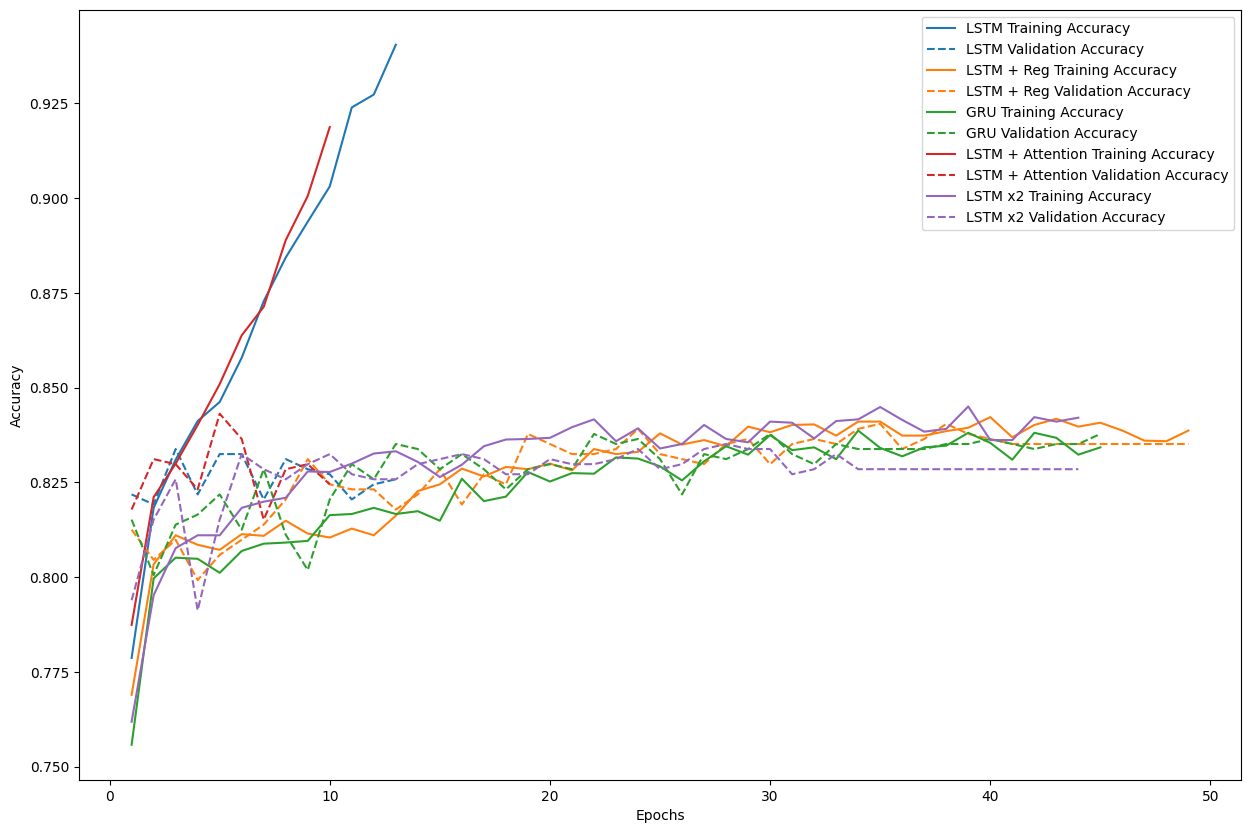

In [43]:
plt.figure(figsize = (15, 10))

bd_lstm_acc = bd_lstm_training['accuracy']
bd_lstm_reg_acc = bd_lstm_reg_training['accuracy']
bd_gru_acc = bd_gru_training['accuracy']
bd_lstm_att_acc = bd_lstm_att_training['accuracy']
bd_lstm_x2_acc = bd_lstm_x2_training['accuracy']

bd_lstm_val_acc = bd_lstm_training['val_accuracy']
bd_lstm_reg_val_acc = bd_lstm_reg_training['val_accuracy']
bd_gru_val_acc = bd_gru_training['val_accuracy']
bd_lstm_att_val_acc = bd_lstm_att_training['val_accuracy']
bd_lstm_x2_val_acc = bd_lstm_x2_training['val_accuracy']

plt.plot(np.arange(1, len(bd_lstm_acc) + 1), bd_lstm_acc, color = 'C0', label = 'LSTM Training Accuracy')
plt.plot(np.arange(1, len(bd_lstm_acc) + 1), bd_lstm_val_acc, '--', color = 'C0', label = 'LSTM Validation Accuracy')

plt.plot(np.arange(1, len(bd_lstm_reg_acc) + 1), bd_lstm_reg_acc, color = 'C1', label = 'LSTM + Reg Training Accuracy')
plt.plot(np.arange(1, len(bd_lstm_reg_acc) + 1), bd_lstm_reg_val_acc, '--', color = 'C1', label = 'LSTM + Reg Validation Accuracy')

plt.plot(np.arange(1, len(bd_gru_acc) + 1), bd_gru_acc, color = 'C2', label = 'GRU Training Accuracy')
plt.plot(np.arange(1, len(bd_gru_acc) + 1), bd_gru_val_acc, '--', color = 'C2', label = 'GRU Validation Accuracy')

plt.plot(np.arange(1, len(bd_lstm_att_acc) + 1), bd_lstm_att_acc, color = 'C3', label = 'LSTM + Attention Training Accuracy')
plt.plot(np.arange(1, len(bd_lstm_att_acc) + 1), bd_lstm_att_val_acc, '--', color = 'C3', label = 'LSTM + Attention Validation Accuracy')

plt.plot(np.arange(1, len(bd_lstm_x2_acc) + 1), bd_lstm_x2_acc, color = 'C4', label = 'LSTM x2 Training Accuracy')
plt.plot(np.arange(1, len(bd_lstm_x2_acc) + 1), bd_lstm_x2_val_acc, '--', color = 'C4', label = 'LSTM x2 Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

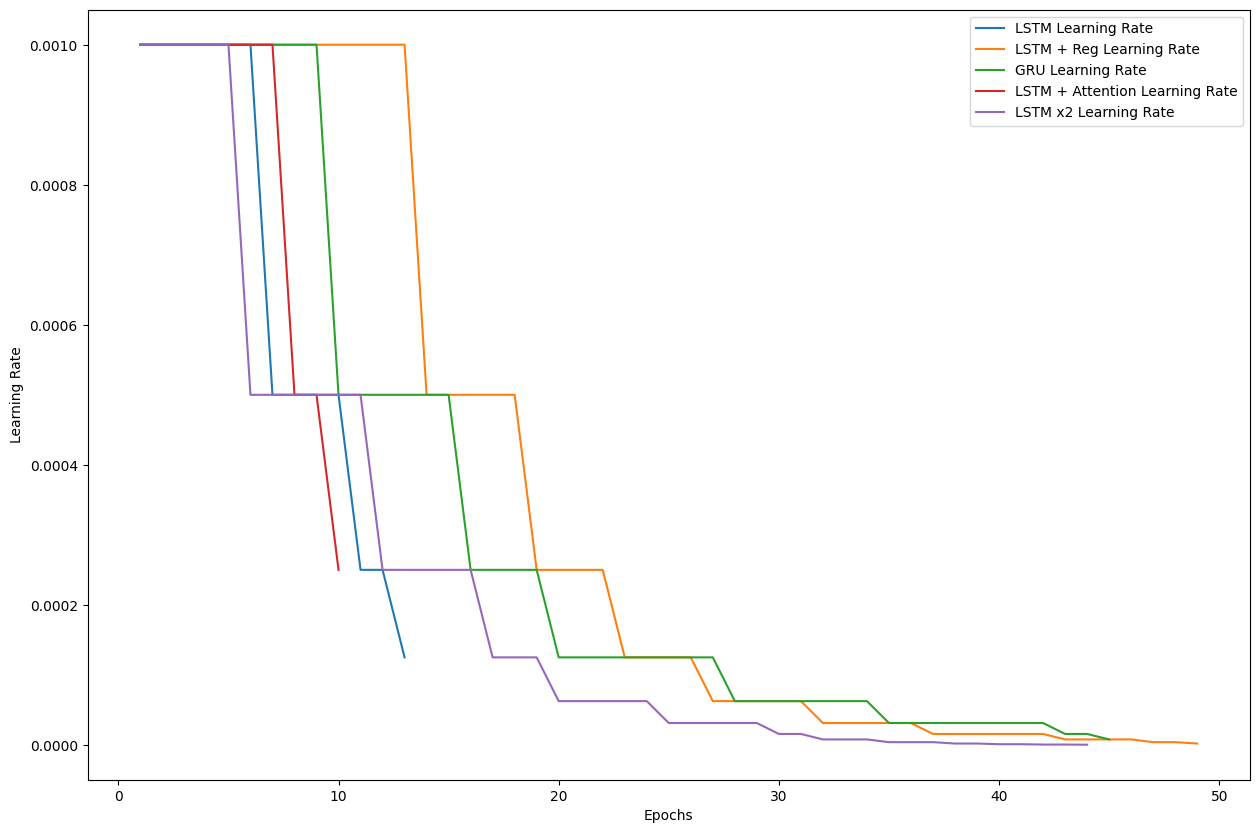

In [44]:
plt.figure(figsize = (15, 10))

bd_lstm_lr = bd_lstm_training['learning_rate']
bd_lstm_reg_lr = bd_lstm_reg_training['learning_rate']
bd_gru_lr = bd_gru_training['learning_rate']
bd_lstm_att_lr = bd_lstm_att_training['learning_rate']
bd_lstm_x2_lr = bd_lstm_x2_training['learning_rate']

plt.plot(np.arange(1, len(bd_lstm_lr) + 1), bd_lstm_lr, color = 'C0', label = 'LSTM Learning Rate')


plt.plot(np.arange(1, len(bd_lstm_reg_lr) + 1), bd_lstm_reg_lr, color = 'C1', label = 'LSTM + Reg Learning Rate')


plt.plot(np.arange(1, len(bd_gru_lr) + 1), bd_gru_lr, color = 'C2', label = 'GRU Learning Rate')


plt.plot(np.arange(1, len(bd_lstm_att_lr) + 1), bd_lstm_att_lr, color = 'C3', label = 'LSTM + Attention Learning Rate')


plt.plot(np.arange(1, len(bd_lstm_x2_lr) + 1), bd_lstm_x2_lr, color = 'C4', label = 'LSTM x2 Learning Rate')


plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()

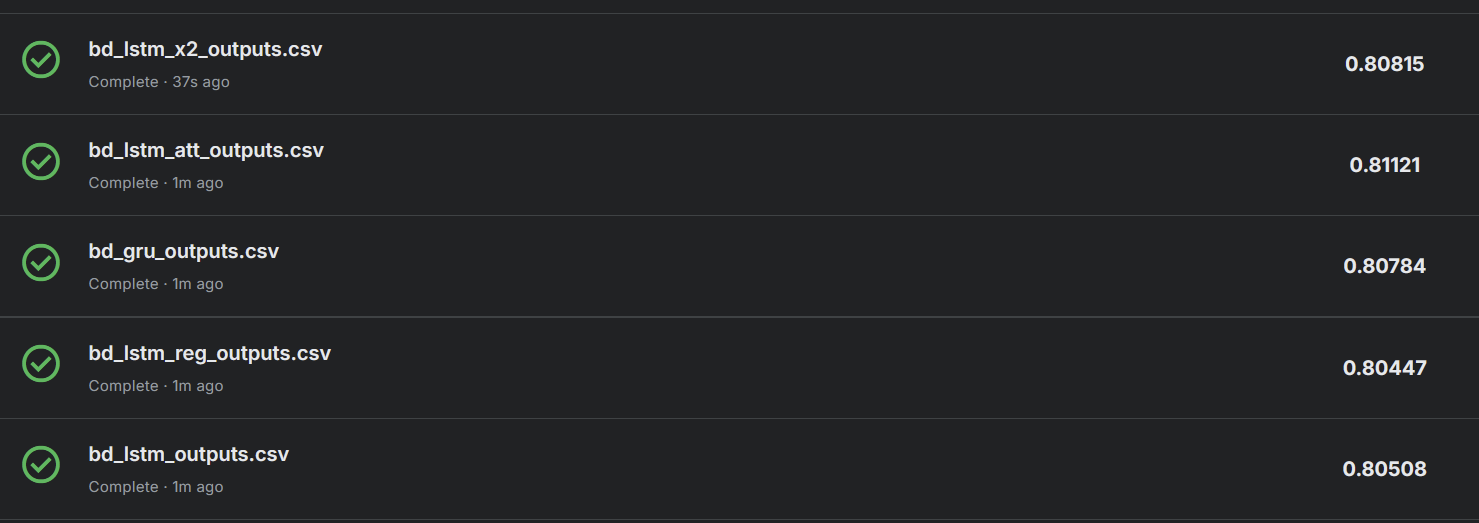

From the results, we can see that the 5 different models performed similarly, with the LSTM with attention model doing the best. From looking at the training accuracy and validation accuracy graphs, we can see that the models without regularization train very quickly, but the validation accuracy does not improve compared to the training accuracy. 

Regularization, as expected, keeps the model from overfitting the training data, and the validation and training accuracies for those models behave similarly. 

The learning rate reduction seems to have helped, as we can see multiple reductions when the validation accuracies plateau and early stopping is not triggered as the training validation performance continues improving. 

Attention or a more complex model, such as the 2 layer LSTM model, performed the best, suggesting that a more complex model may help.

Surprisingly, the GRU model outperformed the LSTM model. One possible reason for this is that the dataset is fairly small and the GRU model was able to generalize better. 

# Conclusion

From the results, I can see that regularization may help with fine-tuning models, as it helps the model from overfitting on the training data and generalize better. However, depending on the limitations of the model, it may not be able to learn some complexe features, as the results also show that there is little difference between the results. Alternatively, the models may have performed simiarly because of the extensive data cleaning taken from Gunes Evitan's notebook. 

For improvements, I would do more exploratory data analysis, as some of the extra features chosen may not help as much from looking at the data distributions. I would also try using some of the n-grams for the vocabulary instead of just the uni-grams used for the model. 

For a much better score, I would try using a pre-made model such as the BERT models used in the pinned notebooks for this competition. However, as a learning exercise, I think trying to make my own models was a valuable experience. 

# References

Gunes Evitan's Notebook\
https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook